# Case DS - Prevendo a quantidade vendida
O objetivo deste case é prever a quantidade vendida de cada um dos items nos ciclos 202016, 202017 e 202101.

In [129]:
# Bibliotecas para lidar com os DataSets
import sqlite3
import pandas as pd
import numpy as np

# para os graficos
import matplotlib.pyplot as plt
import seaborn as sns

# Box-cox transform
from scipy.stats import boxcox

# para realizar o train-test split
from sklearn.model_selection import train_test_split

# modelo de regressao linear
from sklearn.linear_model import LinearRegression

# Importando a validacao cruzada
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict

# importando ransom forest
from sklearn.ensemble import RandomForestRegressor

# GridSearchCV
from sklearn.model_selection import GridSearchCV

# modelo de clusterizacao
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Prepreocessamento
from sklearn.preprocessing import StandardScaler

# Metricas para avaliacao
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score

In [2]:
# Conectando com a base
conn = sqlite3.connect('case_ds_gdem.sqlite3')

In [3]:
# Criando o dataframe a partir da tabela "vendas" da base de dados
df = pd.read_sql_query("SELECT * FROM vendas", conn)

In [4]:
# Linhas e colunas
print(df.shape)

# Visualizando amostra do DF
df.head()

(52094, 14)


,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,PCT_DESCONTO,VL_PRECO,QT_VENDA
0,6246,201908,anon_S12,anon_S53,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,461.4,240.0
1,6246,201915,anon_S12,anon_S53,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,461.4,240.0
2,6306,201916,anon_S12,anon_S53,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,521.4,240.0
3,6480,201801,anon_S12,anon_S17,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,833.4,528.0
4,6480,201802,anon_S12,anon_S17,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,833.4,564.0


In [5]:
# infos gerais sobre o dataset - tipos e nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52094 entries, 0 to 52093
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   COD_MATERIAL            52094 non-null  int64  
 1   COD_CICLO               52094 non-null  int64  
 2   DES_CATEGORIA_MATERIAL  52094 non-null  object 
 3   DES_MARCA_MATERIAL      52094 non-null  object 
 4   FLG_DATA                52094 non-null  int64  
 5   FLG_CAMPANHA_MKT_A      52094 non-null  float64
 6   FLG_CAMPANHA_MKT_B      52094 non-null  float64
 7   FLG_CAMPANHA_MKT_C      52094 non-null  float64
 8   FLG_CAMPANHA_MKT_D      52094 non-null  float64
 9   FLG_CAMPANHA_MKT_E      52094 non-null  float64
 10  FLG_CAMPANHA_MKT_F      52094 non-null  float64
 11  PCT_DESCONTO            16780 non-null  float64
 12  VL_PRECO                52088 non-null  float64
 13  QT_VENDA                48946 non-null  float64
dtypes: float64(9), int64(3), object(2)
mem

## Verificando se existem dados duplicados

In [6]:
# verificando a existencia de dados duplicados baseando-se em todas as colunas
num_duplicates = df.duplicated().sum()
print(f"Number of duplicates: {num_duplicates}")

Number of duplicates: 0


## Tipos

In [7]:
# Divisao inicial dos tipos de dados
categoricas_numericas = ['COD_MATERIAL', 'COD_CICLO']
categoricas = ['DES_CATEGORIA_MATERIAL', 'DES_MARCA_MATERIAL']
bools = ['FLG_DATA']
campanhas_mkt = ['FLG_CAMPANHA_MKT_A', 'FLG_CAMPANHA_MKT_B', 'FLG_CAMPANHA_MKT_C', 'FLG_CAMPANHA_MKT_D','FLG_CAMPANHA_MKT_E', 'FLG_CAMPANHA_MKT_F']
numericas = ['PCT_DESCONTO', 'VL_PRECO']
target = ['QT_VENDA']

## Sumarizando estatisticas das variaveis numericas

In [8]:
cont_vars = ['PCT_DESCONTO', 'VL_PRECO', 'QT_VENDA']
df_cont = df[cont_vars]
df_cont.describe()

,PCT_DESCONTO,VL_PRECO,QT_VENDA
count,16780.000000,52088.000000,4.894600e+04
mean,19.461982,544.998243,3.400405e+04
std,77.696194,250.925173,9.812367e+04
min,0.000000,234.060000,2.350000e+02
25%,15.000000,389.400000,8.100000e+02
50%,20.000000,461.400000,5.880000e+03
75%,25.035000,593.400000,2.996400e+04
max,10000.000000,5539.620000,4.047372e+06


Com isso temos algumas pistas:
- PCT_DESCONTO: 
    - O percentil 75 nos da um valor de 25%
    - O valor maximo consta como 10000%, algo estranho que demonstra a presenca de outliers e deve ser investigado mais adiante
- VL_PRECO:
    - Aqui existem alguns valores extremos, vale uma investigação mais adiante pensando na retirada de alguns destes
- QT_VENDA:
    - Para o target existem também valores extremos, estes podem apresentar a presença de outliers 

## Problema e pontos iniciais a serem considerados
Neste problema temos que fazer a previsao da quantidade de produtos vendidos para os ciclos 202016, 202017, 202101. Aqui temos um aspecto temporal a ser levado em conta.
  
Vamos então ter em mente alguns pontos iniciais:
- Teremos em nossa variável temporal todos os diferentes ciclos 
- Os itens podem ou não estar presentes para todos os ciclos ou apenas parte deles, já que velhos itens podem ser descontinuados e novos podem ser lançados ou pode até mesmo haver relanlançamento
- A quantidade de produtos vendidos é agrupada pro ciclo, independentemente se todos os ciclos estão ou não presentes para o produto

In [9]:
# verificando os diferentes valores de ciclo
cod_ciclo_values = sorted(df['COD_CICLO'].unique())
print(cod_ciclo_values)

[201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812, 201813, 201814, 201815, 201816, 201817, 201818, 201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912, 201913, 201914, 201915, 201916, 201917, 202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012, 202013, 202014, 202015, 202016, 202017, 202101]


Aqui vemos que realmente todos os ciclos estão presentes, incluindo os de interesse para nossa previsão:  202016, 202017, 202101. Antes de seguir a análise pode-se dizer o seguinte:
- o máximo número de ciclos presentes e igual a 18
- Pensando mais adiante essa variável deverá ser tratada para utilização no modelo. No tratamento da mesma podemos utilizar a seguinte abordagem:
    - quebrar em duas colunas a coluna ciclo que apresenta os possíveis ciclos de 1 até 18
    - a segunda coluna seria a coluna ano, aqui pode ser feito um mapeamento com o ano mais antigo igual a zero e o mais novo igual a 3
    - Talvez seja interessante ter os valores ordenados já que a quantidade vendida de tempos mais antigos pode ter sido alterada com o passar do tempo
  
Agora vejamos se os dados estao realmente agrupados por ciclos com algumas amostras dos dados.

In [10]:
# configurando para ver mais linhas
pd.set_option('display.max_rows', 100)

# selecionando aleatoriamente 3 produtos diferentes
cod_material_values = df['COD_MATERIAL'].sample(n=3, random_state=42).tolist()

# filtrando o dataframe para que o mesmo contenha apenas estes produtos
df_sample = df[df['COD_MATERIAL'].isin(cod_material_values)]

# display the sample dataframe
df_sample.head(100)


,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,PCT_DESCONTO,VL_PRECO,QT_VENDA
37505,432528,201801,anon_S2,anon_S13,0,0.0,1.0,1.0,0.0,0.0,0.0,21.1100,413.415,48864.0
37506,432528,201802,anon_S2,anon_S13,0,0.0,1.0,0.0,0.0,0.0,0.0,10.0000,466.815,18660.0
37507,432528,201803,anon_S2,anon_S13,0,0.0,1.0,1.0,0.0,0.0,0.0,23.1400,413.745,45876.0
37508,432528,201804,anon_S2,anon_S13,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,467.400,20790.0
37509,432528,201805,anon_S2,anon_S13,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,467.400,14394.0
37510,432528,201806,anon_S2,anon_S13,0,0.0,1.0,0.0,0.0,0.0,0.0,23.1400,414.765,30738.0
37511,432528,201807,anon_S2,anon_S13,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,467.400,19284.0
37512,432528,201808,anon_S2,anon_S13,0,0.0,1.0,0.0,0.0,0.0,0.0,28.2800,401.700,42426.0
37513,432528,201809,anon_S2,anon_S13,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,466.470,14790.0
37514,432528,201810,anon_S2,anon_S13,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,467.400,16668.0


Com essa amostra pudemos verificar que os valores realmente estão agrupados por ciclo, além disso temos uma nova hipótese, a de que os valores nulos de QT_VENDA sinalizados em `df.info()`se devem ao fato destes terem que ser previstos, ou seja, vamos prever este valores sem comparar com o resultado real.

# Missing Values
Primeiramente vamos verificar as variáveis que contem dados ausentes

In [11]:
# criando uma lista com as variaveis que possuem valores faltantes
vars_na = [var for var in df.columns if df[var].isnull().sum() > 0]

# Determinando o percentual de valores faltando (expressos como decimais)
df[vars_na].isnull().mean().sort_values(ascending=True)

VL_PRECO        0.000115
QT_VENDA        0.060429
PCT_DESCONTO    0.677890
dtype: float64

In [12]:
df.shape

(52094, 14)

## O Target possui nulos
Nossa variavel alvo (QT_VENDA) possui valores nulos, logo, vamos levar em conta a hipótese levantada anteriormente sobre os nulos verificando os valores das mesmas por ciclo.

In [13]:
# verificando os percentuais (%) valores nulos do target para cada ciclo
valores_na_ciclo = df.groupby('COD_CICLO')['QT_VENDA'].apply(lambda x: x.isna().sum() / len(x) * 100)
print(valores_na_ciclo)


COD_CICLO
201801      0.0
201802      0.0
201803      0.0
201804      0.0
201805      0.0
201806      0.0
201807      0.0
201808      0.0
201809      0.0
201810      0.0
201811      0.0
201812      0.0
201813      0.0
201814      0.0
201815      0.0
201816      0.0
201817      0.0
201818      0.0
201901      0.0
201902      0.0
201903      0.0
201904      0.0
201905      0.0
201906      0.0
201907      0.0
201908      0.0
201909      0.0
201910      0.0
201911      0.0
201912      0.0
201913      0.0
201914      0.0
201915      0.0
201916      0.0
201917      0.0
202001      0.0
202002      0.0
202003      0.0
202004      0.0
202005      0.0
202006      0.0
202007      0.0
202008      0.0
202009      0.0
202010      0.0
202011      0.0
202012      0.0
202013      0.0
202014      0.0
202015      0.0
202016    100.0
202017    100.0
202101    100.0
Name: QT_VENDA, dtype: float64


Neste ponto a hipótese foi  validada, os valores nulos presentes se referem aos valores que devem ser previstos. Este fato nos leva a um ponto muito importante, quando o split for feito para separar os dados para treino e teste deveremos ter dados de treino, de teste (estes serao comparados com os valores reais para que tenhamos a acuracia do modelo) e os dados para a previsão.

Para as outras variáveis com valores nulos VL_PRECO possui uma quantidade muito pequena de dados faltantes, o que pode ser substituido pela média ou mediana mais adiante se necessario (dependendo das analises futuras).  
Já a variável PCT_DESCONTO deve ser analisada com maior cuidado, pode ser que os valores nulos possam ser encarados como 0, ou seja, sem desconto, ou podemos substituir pela mediana/média.

In [14]:
'''
    Fcn que verifica os valores nulos presentes para uma variavel var
    em um dataframe df. Com isso analisamos a media do target para quando
    o valor esta presente ou nao.
    Parametros:
        - df: dataframe de interesse
        - var: variavel com nulos a ser analisada
'''
def analyse_na_value(df, var):
    # criando uma copia do df para naoo escrever por cima dos dados
    df = df.copy()
    
    # Vamos criar uma variavel indicando 1 se a observacao for faltante
    # caso contrario o valor sera zero
    df[var] = np.where(df[var].isnull(), 1, 0)
    
    # vamos comparar a quantidade de produtos vendidos nas observacoes
    # com e sem dado
    
    # determinar a media das quantidades de vendas nos grupos 0 e 1
    # assim como o desvio padrao da quantidade de produtos dendidos
    # capturando o resultado em um dataset temporario
    tmp = df.groupby(var)['QT_VENDA'].agg(['mean'])
    
    # plotar um grafico de barras das medias das vendas nos grupos 0 e 1
    sns.barplot(x=var, y='mean', data=tmp.reset_index())
    plt.ylabel('Media de quantidades vendidas')
    plt.show()

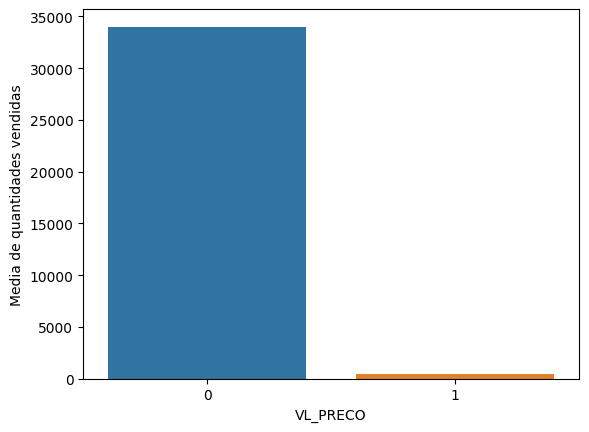

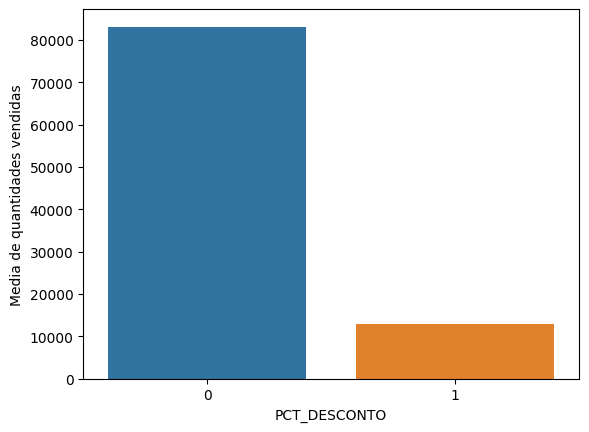

In [15]:
for var in ['VL_PRECO', 'PCT_DESCONTO']:
    analyse_na_value(df, var)

(0.0, 1750.0)

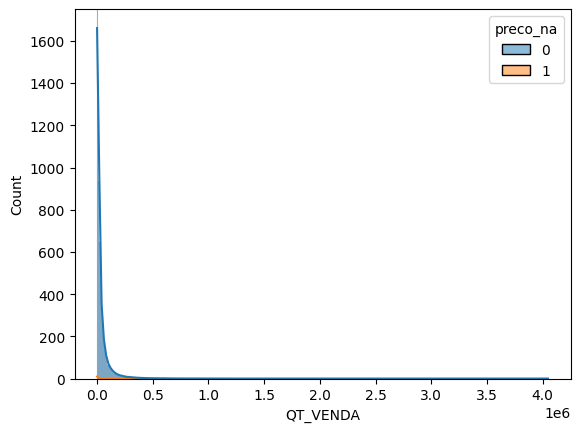

In [16]:
# Analise da distribuicao das variaveis para valores faltantes e nao faltantes
# Criando uma copia do df
df_copy_nas = df.copy()

# criando uma variavel binaria para indicar valores faltantes
df_copy_nas['preco_na'] = df_copy_nas['VL_PRECO'].isnull().astype(int)
df_copy_nas['desconto_na'] = df_copy_nas['PCT_DESCONTO'].isnull().astype(int)

# plotar a distribuicao deQ_VENDA para  valores faltantes e nao faltantes de vl_preco
sns.histplot(data=df_copy_nas, x='QT_VENDA', hue='preco_na', kde=True)
plt.ylim(0, 1750)

(0.0, 3100.0)

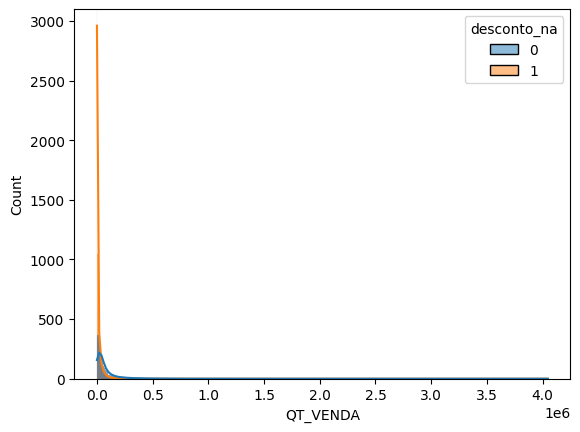

In [17]:
sns.histplot(data=df_copy_nas, x='QT_VENDA', hue='desconto_na', kde=True)
plt.ylim(0, 3100)

Verificando a média de produtos vendidos com desconto parece que este item não tem tanta relevancia. Mas, na distribuição vemos o na verdade existe sim relevância. Vale fazer uma investigacao maior para entender a influencia das campanhas na quantidade de produtos vendida.

### Váriavel campanhas de marketing
Está variável não possui nulos, mas, olhando as amostras de dados parece possuir muitos valores iguais a zero, vamos verificar este ponto.

In [18]:
# verificar o percentual de campanhas igual a 0 para cada uma das campanhas
for campanha in campanhas_mkt:
    percentage = (df[campanha] == 0.0).sum() / len(df) * 100
    print('{}: {}'.format(campanha, percentage))

FLG_CAMPANHA_MKT_A: 98.44895765347258
FLG_CAMPANHA_MKT_B: 72.94890006526663
FLG_CAMPANHA_MKT_C: 95.9957000806235
FLG_CAMPANHA_MKT_D: 87.5167965600645
FLG_CAMPANHA_MKT_E: 100.0
FLG_CAMPANHA_MKT_F: 100.0


Aqui podemos ver que 100% dos valores de indicadores de campanha sao iguais a 0.0 para as campanhas E e F, ou seja, essas campanhas não estão presentes para estes cilos, logo essas colunas podem ser descartadas.  
Vejamos agora os diferentes valores que estas colunas podem apresentar. 

In [19]:
distinct_values = df['FLG_DATA'].unique()
print(distinct_values)

[1 0]


In [20]:
distinct_values = df['FLG_CAMPANHA_MKT_A'].unique()
print(distinct_values)

[0.         1.         0.66666667 0.5        0.33333333 0.25      ]


In [21]:
distinct_values = df['FLG_CAMPANHA_MKT_B'].unique()
print(distinct_values)

[0.         1.         0.5        0.25       0.33333333 0.66666667
 0.75      ]


In [22]:
distinct_values = df['FLG_CAMPANHA_MKT_C'].unique()
print(distinct_values)

[0.         1.         0.5        0.66666667]


In [23]:
distinct_values = df['FLG_CAMPANHA_MKT_D'].unique()
print(distinct_values)

[0.         0.5        0.25       0.33333333 0.66666667 1.
 0.75      ]


Sem mais informações pode-se deduzir que esses valores se referem a intensidade ou proporção da campanha. Uma ideia seria fazer uma nova coluna indicando se uma campanha de marketing existe ou não e verificar a quantidade de 0s novamente.  
A abordagem será decidida mais aiante, mas aqui será feita uma análise prévia.

In [24]:
# criando uma copia do df 
df_mkt = df.copy()

# criar uma nova coluna com valo 1 caso o item apresente alguma das 
# campanhas de marketing, caso contrario 0
df_mkt['flg_mkt'] = np.where((df_mkt[campanhas_mkt] != 0).any(axis=1), 1, 0)

df_mkt.shape

(52094, 15)

In [25]:
# verificando o percentual de campanhas existentes
perc_flg_mkt = (df_mkt['flg_mkt'] == 0).sum() / len(df) * 100

print(perc_flg_mkt)

67.79475563404614


In [26]:
df_mkt.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,PCT_DESCONTO,VL_PRECO,QT_VENDA,flg_mkt
0,6246,201908,anon_S12,anon_S53,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,461.4,240.0,0
1,6246,201915,anon_S12,anon_S53,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,461.4,240.0,0
2,6306,201916,anon_S12,anon_S53,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,521.4,240.0,0
3,6480,201801,anon_S12,anon_S17,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,833.4,528.0,0
4,6480,201802,anon_S12,anon_S17,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,833.4,564.0,0


Com o valor de 67.8 de valores iguais a 0 temos um cenário mais balanceado e interessante para seguir com a análise, se tornando uma possibilidade válida a ser decidida mais adiante.

# Distribuição do target e Análise de Outliers da mesma

(0.0, 2000.0)

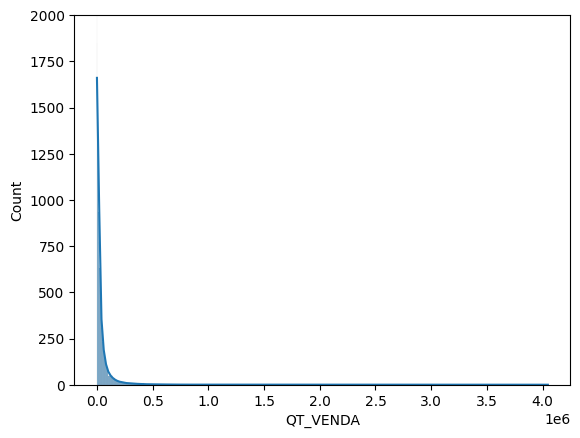

In [27]:
# distribuicao do target
sns.histplot(data=df, x='QT_VENDA', kde=True)
plt.ylim(0, 2000)

Com o gráfico de distribuição vemos que a variável a ser prvista QT_VENDA possui valores extremos. Vejamos o boxplot da mesma.  
Além disso, quando estou lidando com outliers gosto de duas abordagens. Primeiro verificar o boxplot para obter alguns insights e decidir entre usar o IQR para remover estes ou remover os upper 1%-2% dependendo do cenário.

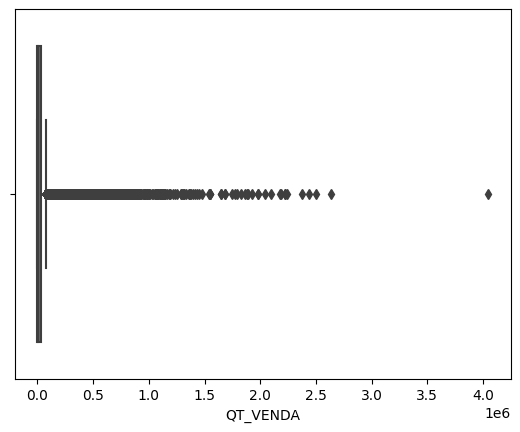

In [28]:
sns.boxplot(x=df['QT_VENDA']);

No boxplot vemos que realmente existe a presenca de valores extremos e outliers. o valor de 4.047e+06 realmente esta muito acima vejamos mais detalhes deste.

In [29]:
df_venda_4M = df[df['QT_VENDA'] > 4000000].copy()

df_venda_4M.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,PCT_DESCONTO,VL_PRECO,QT_VENDA
27435,177396,202013,anon_S2,anon_S4,0,0.0,1.0,1.0,0.0,0.0,0.0,15.8,713.505,4047372.0


é interessante notar que para este item existem duas campanhas de marketing e também um desconto para este ciclo.

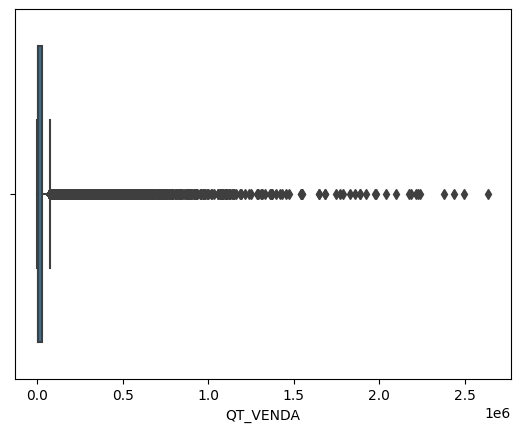

In [30]:
teste_out_1 = df[df['QT_VENDA'] < 4000000].copy()

sns.boxplot(x=teste_out_1['QT_VENDA']);

Tirando o outlier ainda temos valores extremos, vamos verificar os percentis 99 e 98 e verificar amostras destes dados.
 
**NOTA:** Se der tempo fazer a somatoria das campanhas de marketing e verificar como se distribuem as categorias.

In [31]:
percentile_99 = df['QT_VENDA'].quantile(0.99)
percentile_98 = df['QT_VENDA'].quantile(0.98)
print(percentile_99)
print(percentile_98)

418508.1000000007
275433.6


Vejamos uma amostra dos upper 1%.

In [32]:
df_venda_4k = df[df['QT_VENDA'] > 418508.1].copy()

df_venda_4k.head(50)

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,PCT_DESCONTO,VL_PRECO,QT_VENDA
1177,61326,201814,anon_S12,anon_S39,0,0.0,1.0,0.0,0.00,0.0,0.0,30.2400,635.415,460968.0
1185,61326,201904,anon_S12,anon_S39,0,0.0,1.0,0.0,0.00,0.0,0.0,30.2400,635.955,441444.0
1197,61326,201916,anon_S12,anon_S39,1,0.0,1.0,0.0,0.00,0.0,0.0,32.5600,605.775,867456.0
1199,61326,202001,anon_S12,anon_S39,0,0.0,1.0,1.0,0.00,0.0,0.0,30.0000,641.520,492438.0
2358,69198,201802,anon_S12,anon_S28,0,0.0,1.0,1.0,0.00,0.0,0.0,21.1350,683.490,1314702.0
2360,69198,201804,anon_S12,anon_S28,0,0.0,1.0,0.0,0.00,0.0,0.0,21.1350,683.505,1191564.0
2362,69198,201806,anon_S12,anon_S28,0,0.0,0.0,0.0,0.25,0.0,0.0,10.0000,697.005,734436.0
2363,69198,201807,anon_S12,anon_S28,1,0.0,1.0,0.0,0.25,0.0,0.0,31.2725,662.400,1646142.0
2365,69198,201809,anon_S12,anon_S28,1,0.0,0.0,0.0,0.50,0.0,0.0,0.0000,779.100,485358.0
2367,69198,201811,anon_S12,anon_S28,0,0.0,0.0,0.0,0.00,0.0,0.0,NaN,737.625,774936.0


In [35]:
# contando as observacoes
upper_2_count = (df['QT_VENDA'] > 275433.6).sum()

print(upper_2_count)

979


In [36]:
upper_1_count = (df['QT_VENDA'] > 418508.1).sum()

print(upper_1_count)

490


In [37]:
# pegando um item como amostra para verificacao
df_69198 = df[df['COD_MATERIAL'] == 69198].copy()

df_69198.head(50)

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,PCT_DESCONTO,VL_PRECO,QT_VENDA
2357,69198,201801,anon_S12,anon_S28,0,0.0,1.0,0.0,0.00,0.0,0.0,10.0000,803.400,281928.0
2358,69198,201802,anon_S12,anon_S28,0,0.0,1.0,1.0,0.00,0.0,0.0,21.1350,683.490,1314702.0
2359,69198,201803,anon_S12,anon_S28,0,0.0,0.5,0.0,0.00,0.0,0.0,22.0000,772.980,222642.0
2360,69198,201804,anon_S12,anon_S28,0,0.0,1.0,0.0,0.00,0.0,0.0,21.1350,683.505,1191564.0
2361,69198,201805,anon_S12,anon_S28,0,0.0,0.0,0.0,0.00,0.0,0.0,NaN,803.115,129636.0
2362,69198,201806,anon_S12,anon_S28,0,0.0,0.0,0.0,0.25,0.0,0.0,10.0000,697.005,734436.0
2363,69198,201807,anon_S12,anon_S28,1,0.0,1.0,0.0,0.25,0.0,0.0,31.2725,662.400,1646142.0
2364,69198,201808,anon_S12,anon_S28,0,0.0,0.0,0.0,0.00,0.0,0.0,NaN,802.200,112746.0
2365,69198,201809,anon_S12,anon_S28,1,0.0,0.0,0.0,0.50,0.0,0.0,0.0000,779.100,485358.0
2366,69198,201810,anon_S12,anon_S28,0,0.0,0.0,0.0,0.00,0.0,0.0,NaN,796.485,198678.0


Nessa amostra podemos ver que a maioria dos itens possuem desconto, todos têm alguma campanha em ação (às vezes mais de uma) e muitos deles tem a flag de data comemorativa, ou seja, existe coerência quando vemos valores mais altos para esses itens. E como esses valores provavelmente são de interesse do business talvez seja interessante mantê-los por hora.
  
Ate porque na amostra do item vemos que provavelmente existem itens que realmente vendem mais.

Mas, como o valor de 4.047e+06 parece ser um outlier irei fazer o corte apenas deste valor, até mesmo porque como se encontra bem acima dos outros pode ter sido um erro de base.
 
Apesar de ter ciência de que essa decisão irá provavelmente afetar negativamente as previsões do modelo, o restante do upper 1% será mantido por hora.

In [38]:
df.shape

(52094, 14)

In [39]:
# Retirando valores de quantidade de venda menores que 4000000
df_2 = df[(df['QT_VENDA'] < 4000000) | (df['QT_VENDA'].isnull())].copy()

df_2.shape

(52093, 14)

## Variáveis Categoricas
Vamos agora analisar as variáveis categoricas

In [40]:
# Sabemos que cod_materias deve ter um valor elevado
# logo vamos somente contar os valores distintos para ter ideia do
# no de itens do dataframe
num_itens = df_2['COD_MATERIAL'].nunique()

print(num_itens)

2252


A variável temporal da coluna `COD_CICLO` foi checada no inicio do notebook. Vejamos os valores das colunas categóricas `DES_CATEGORIA_MATERIAL` (categoria do produto) e `DES_MARCA_MATERIAL` (marca do produto)

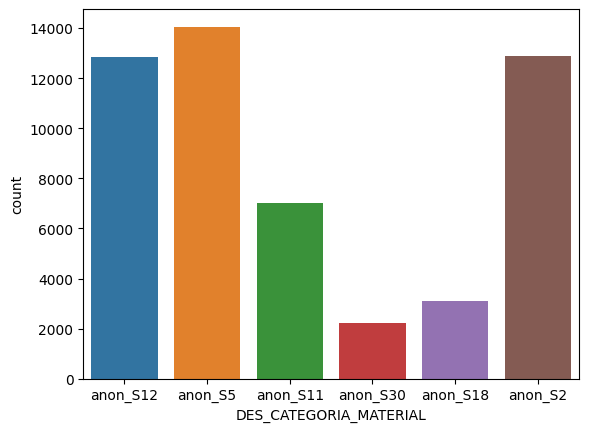

In [41]:
sns.countplot(x='DES_CATEGORIA_MATERIAL', data=df_2)
plt.show();

In [42]:
print(f"Numero de valores distintos para DES_CATEGORIA_MATERIAL: {df['DES_CATEGORIA_MATERIAL'].nunique()}")

Numero de valores distintos para DES_CATEGORIA_MATERIAL: 6


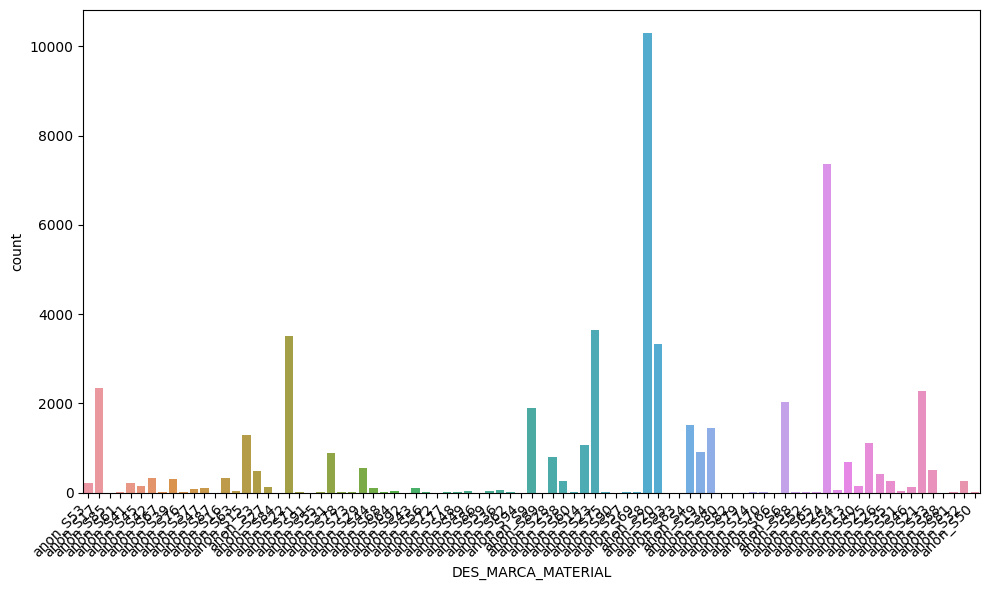

In [43]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='DES_MARCA_MATERIAL', data=df_2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [44]:
print(f"Numero de valores distintos para DES_MARCA_MATERIAL: {df['DES_MARCA_MATERIAL'].nunique()}")

Numero de valores distintos para DES_MARCA_MATERIAL: 85


Acima podemos ver que com relação à categoria temos quantidades de produtos mais balanceadas, quanto as marcas, algumas apresentam uma quantia de produtos bem maiores que as outras, certamente existem as marcas que se destacam. Mas também devemos levar em conta que existe um número muito maior de marcas do que de categorias.

## Variável booleana
Temos apenas uma variavel boleana `FLG_DATA` que indica se existem datas comemorativas no ciclo, vejamos as quantidades para cada alternativa

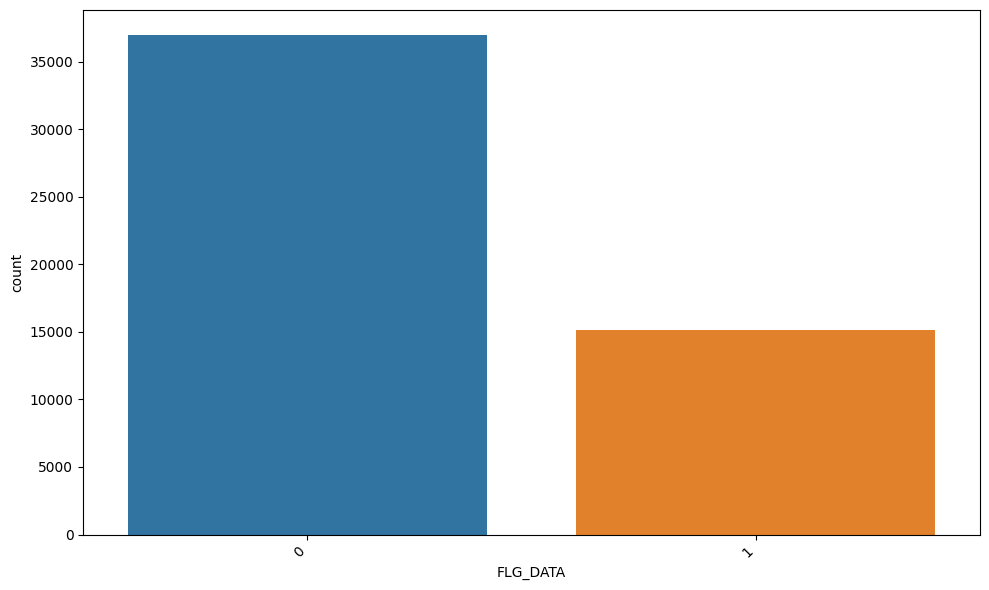

In [45]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='FLG_DATA', data=df_2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

Os valores parecem balanceados para os ciclos com datas comemorativas pensando em datas como dia das mães, pais, namorados, natal, etc que aparecem eventualmente com sasonalidade e possuem historicamente maior volume de vendas.

## Variáveis numéricas
Vamos agora analisar `VL_PRECO` que contém os valores dos produtos e o desconto dado por `PCT_DESCONTO`.

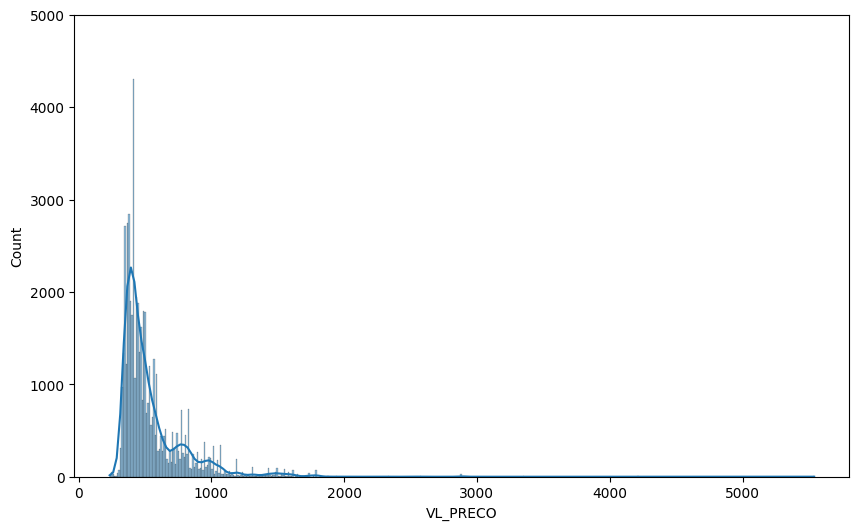

In [46]:
# Distribuicao da varial VL_PRECO
plt.figure(figsize=(10,6))
sns.histplot(data=df_2, x='VL_PRECO', kde=True)
plt.ylim(0, 5000);

Como esperado ao analisar o resumo das estatísticas existem valores extremos, vamos analisar o boxplot agora, assim como o upper 1%.

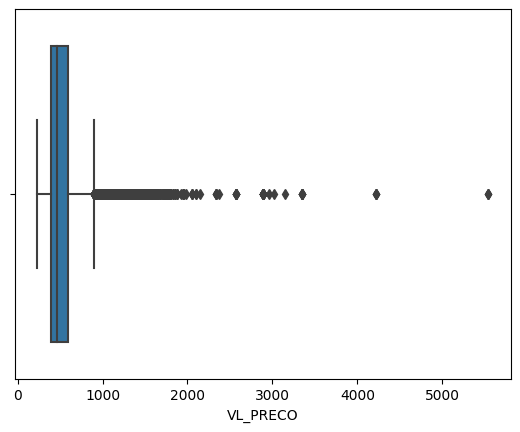

In [47]:
sns.boxplot(x=df_2['VL_PRECO']);

In [48]:
# calculando o 99o percentil
percentile_99_vendas = df_2['VL_PRECO'].quantile(0.99)
print(percentile_99_vendas)

1534.6580999999999


In [49]:
# Verificando a quantidade de observacoes nos upper 1% 
count_upper_1 = len(df[df['VL_PRECO'] >= 1534.65])
print(count_upper_1)

521


In [50]:
# Verificando a quantidade de observacoes com valores maiores ou iguais a 2500
count_upper_1 = len(df[df['VL_PRECO'] >= 2500])
print(count_upper_1)

50


Observando o valor do percentil 99, vemos que se cortarmos os upper 1% ireos perder muitos dados, pensando que talvez produtos de valores mais altos sejam do interesse do VL_PRECO. Mas, observando o boxplot vemos que existem valores demasiado altos.  
  
Com o auxilio do boxplot parece interessanrte cortar valores acima de 2500, perdendo assim apenas 0.1% de nossos dados, vejamos como ficam a distribuição e boxplot eliminando esses valores.

In [51]:
df_3 = df_2[(df_2['VL_PRECO'] <= 2500) | (df_2['VL_PRECO'].isnull())].copy()

df_3.shape

(52043, 14)

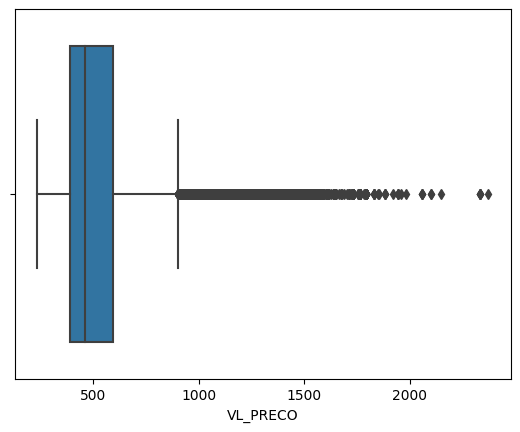

In [52]:
sns.boxplot(x=df_3['VL_PRECO']);

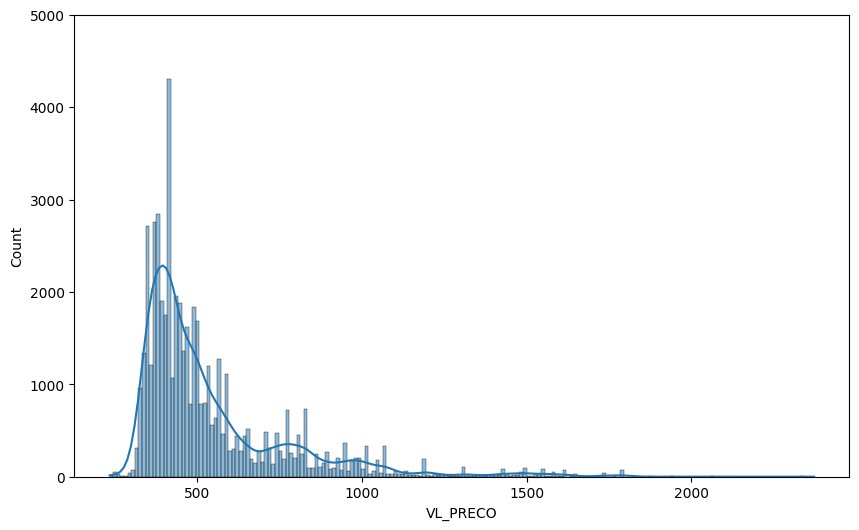

In [53]:
# Distribuicao da varial VL_PRECO
plt.figure(figsize=(10,6))
sns.histplot(data=df_3, x='VL_PRECO', kde=True)
plt.ylim(0, 5000);

Como podemos ver nos graficos, agora temos um cenario melhor distribuido mantendo a maior parte dos valores altos.

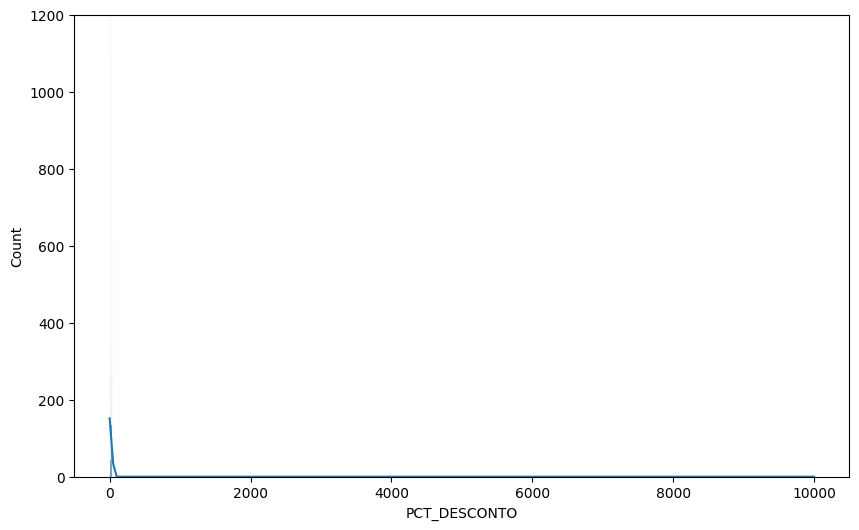

In [54]:
# Distribuicao da varial VL_PRECO
plt.figure(figsize=(10,6))
sns.histplot(data=df_3, x='PCT_DESCONTO', kde=True)
plt.ylim(0, 1200);

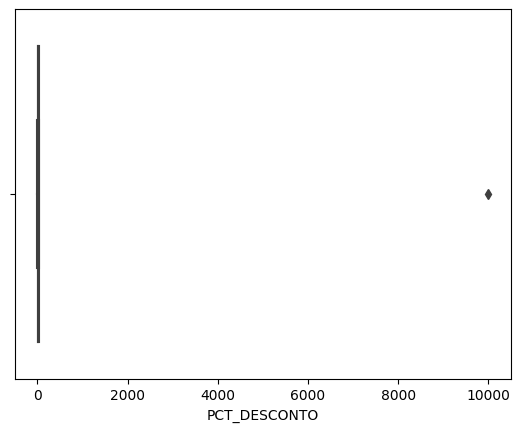

In [55]:
sns.boxplot(x=df_3['PCT_DESCONTO']);

Aqui como podemos ver nos graficos existem evidencias de que houve algum tipo de erro pois o valor de 10000 se apresenta muito alem dos outros valores, logo vamos exluir este

In [56]:
# Retirando o outlier manetendo os NaN
df_4 = df_3[(df_3['PCT_DESCONTO'] < 8000) | (df_3['PCT_DESCONTO'].isnull())].copy()

df_4.shape

(52042, 14)

Vamos agora refazer os graficos anteriores

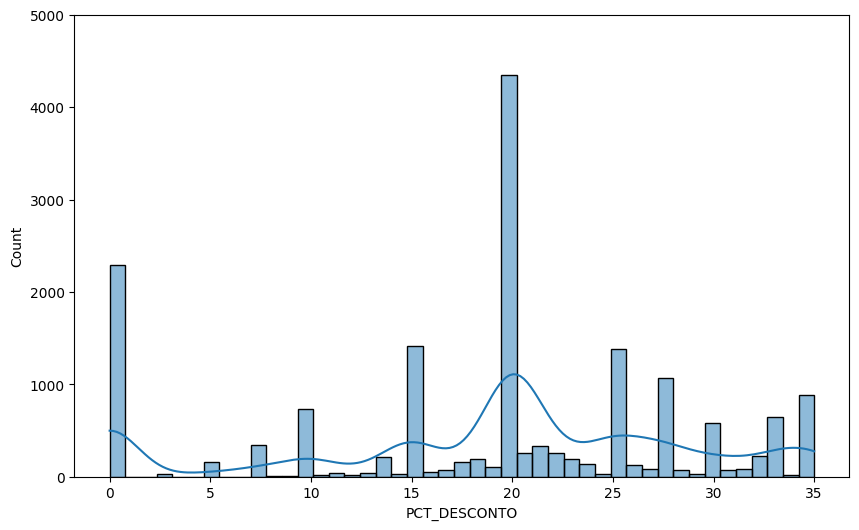

In [57]:
# Distribuicao da varial VL_PRECO
plt.figure(figsize=(10,6))
sns.histplot(data=df_4, x='PCT_DESCONTO', kde=True)
plt.ylim(0, 5000);

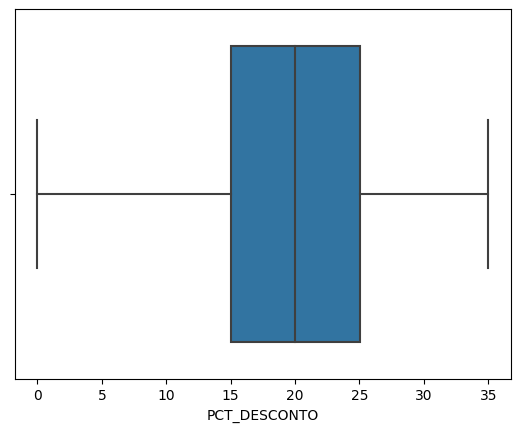

In [58]:
sns.boxplot(x=df_4['PCT_DESCONTO']);

Temos agora valores muito mais coerentes e podemos proseguir com a analise. Como as variáveis relacionadas a campanha de marketing foram analisadas acima vamos agora podemos seguir para as próximas análises.

## Analisando a relação entre as variáveis categóricas e o target

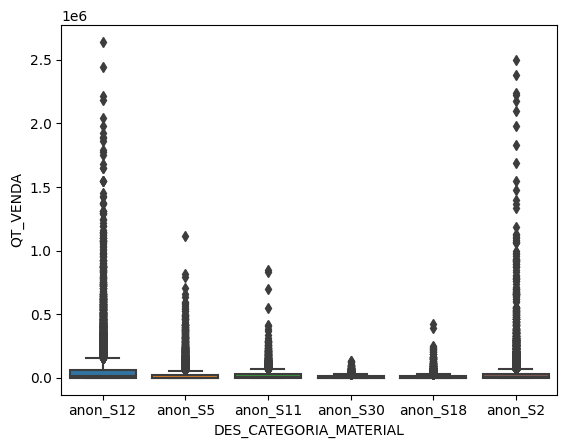

In [59]:
# avaliando DES_CATEGORIA_MATERIAL
sns.boxplot(x=df_4['DES_CATEGORIA_MATERIAL'],y=df_4['QT_VENDA']);

Neste boxplot que se refere a categoria do produtovemos que algumas categorias possuem maior quantidades de venda que as demais, como a opção ao analisar a aquantidade vendida foi de manter os valores mais extremos estes seguem presentes na analise.

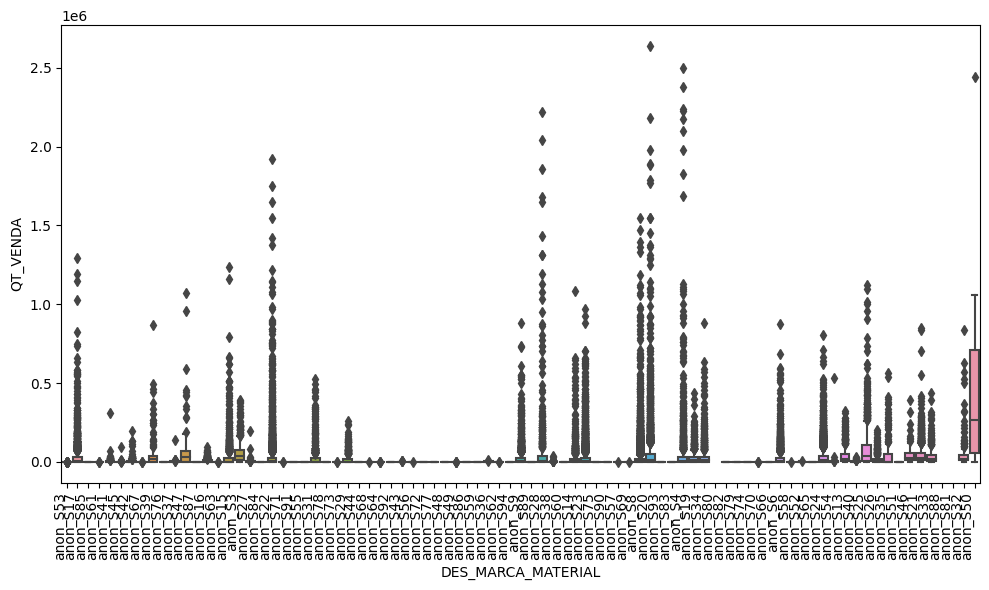

In [60]:
# avaliando DES_MARCA_MATERIAL
plt.figure(figsize=(10,6))
ax = sns.boxplot(x=df_4['DES_MARCA_MATERIAL'],y=df_4['QT_VENDA'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show();

Como observado anteriormente existe um número maior de marcas quando comparadas ao número de categorias, aqui vemos a existencia de alguns candidatos a outliers, ao meso tempo sabe-se que muitas marcas tem seus produtos que seriam os "carro chefe" das mesmas, ou seja, seria interessante manter esses valores de quantidade de venda. 
  
Porem existe uma observacao muito curiosa, para anon_S50, esta possui quantidades de vendas bem maior, e talvez contenha um outlier que poderia ser retirado. Vamos ve-la um pouco mais de perto.

In [61]:
df_anon_S50 = df_4[df_4['DES_MARCA_MATERIAL'] == 'anon_S50']

df_anon_S50.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,PCT_DESCONTO,VL_PRECO,QT_VENDA
49851,460434,202011,anon_S12,anon_S50,1,1.0,0.0,0.0,0.25,0.0,0.0,7.5,799.305,1059066.0
49852,460434,202012,anon_S12,anon_S50,0,1.0,1.0,1.0,0.50,0.0,0.0,25.0,741.900,2440962.0
49853,460434,202013,anon_S12,anon_S50,0,0.0,0.5,0.0,0.00,0.0,0.0,20.0,816.420,724998.0
49854,460434,202014,anon_S12,anon_S50,0,0.0,0.0,0.0,0.00,0.0,0.0,NaN,863.400,247878.0
49855,460434,202015,anon_S12,anon_S50,0,0.0,0.0,0.0,0.00,0.0,0.0,NaN,863.550,282048.0


## Variável temporal

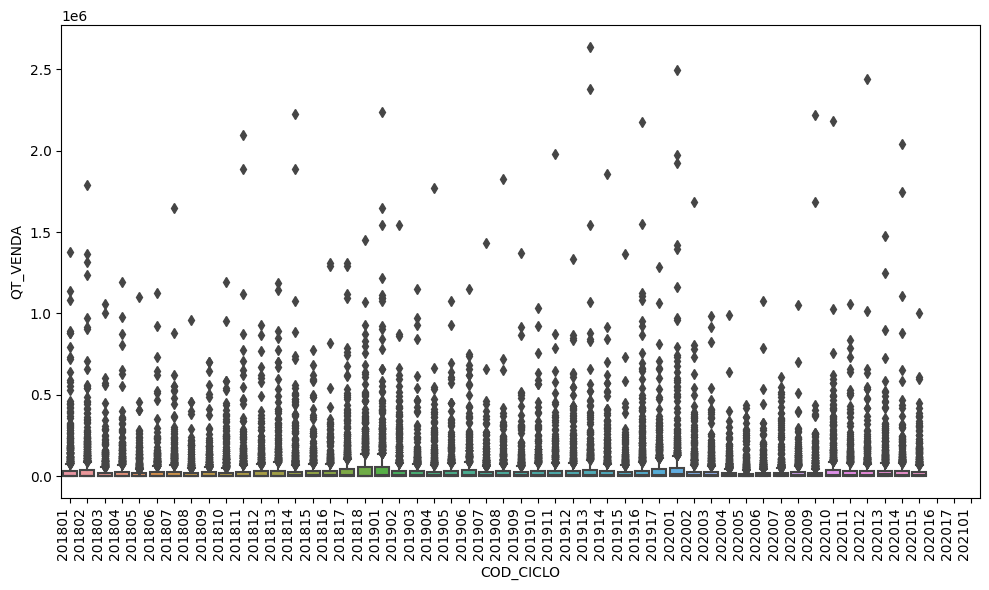

In [62]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x=df_4['COD_CICLO'],y=df_4['QT_VENDA'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show();

Aqui percebemos a existencia de valores estremos, mas existe um certo equilibrio par cada ciclo

## Variáveis campanha de marketing
Aqui iremos excluir as campanhas E e F pois as mesas não estão presentes em nenhuma observação

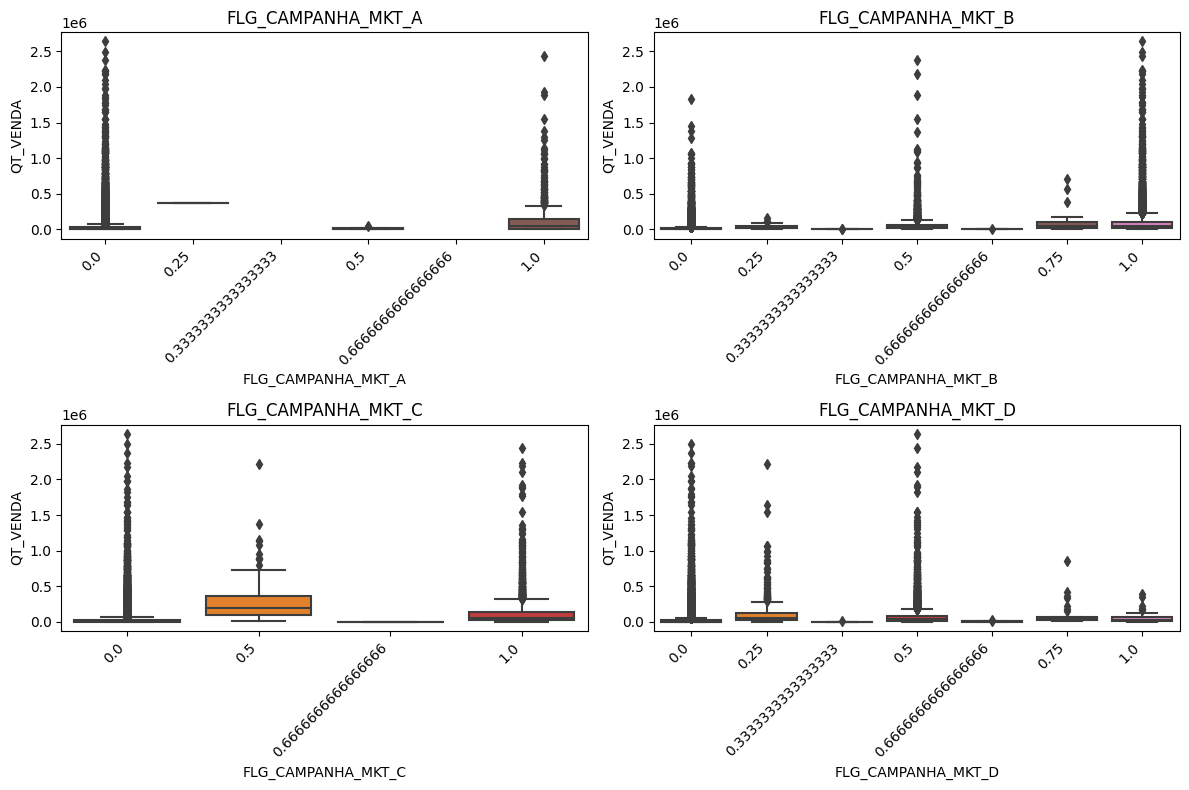

In [63]:
campanhas_mkt_new = ['FLG_CAMPANHA_MKT_A', 'FLG_CAMPANHA_MKT_B', 'FLG_CAMPANHA_MKT_C', 'FLG_CAMPANHA_MKT_D']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, category in enumerate(campanhas_mkt_new):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    sns.boxplot(x=df_4[category], y=df_4['QT_VENDA'], ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_title(category)
    
plt.tight_layout()
plt.show();

Talvez essa seja uma das features mais interessantes do problema, temos diversas campanhas de marketing diferentes, temos 6 campanhas de marketing (AS campanhas E e F não foram mostradas pois tem apenas o valor 0 que indica a ausência de campanha), o que poderia nos fazer pensar que elas se referem às diferentes categorias de produtos já que também temos 6 diferentes. Essa é apenas uma hipótese, até mesmo porque para alguns itens temos mais de uma campanha em ação, logo para ter certeza seriam necessárias mais análises.

Dentro de cada uma dessas campanhas temos numeros variados de "categorias". Esses valores parecem percentuais, poderiam se referir a intensidade de campanha, mas na campanha D, por exemplo, temos quantidades de venda maiores para 0.5 quando comparadas a 0.66 e 0.75. Claro, que os itens de 0.66 poderiam ser mais caros que os de 0.5, podendo a intensidade ainda fazer sentido.

Outra hipótese seria de que esses valores se referem a proporção de lojas, regiões ou até mesmo pessoas atingidas pela campanha. Todas essas hipóteses são válidas mas exigem avançar nesta análise, algo que seria feito mais adiante se possível.
 
Acredito que a melhor forma de tratar os dados da flag de marketing seria criando uma regra mais complexa pensando na proporção de vendas e levando em conta não só a campanha como também os seus diferentes valores. Mas, por hora ficaremos com uma solução mais simples, uma que apenas sinaliza se há ou não uma campanha em ação. Claro que sabemos que isso pode nos levar a erros, mas por hora a escolha é a da abordagem mais simples e direta.

In [64]:
# criando uma copia do df 
df_mkt_2 = df_4.copy()

# criar uma coluna com 1 caso o item apresente alguma das 
# campanhas de marketing, caso contrario 0
df_mkt_2['flg_mkt'] = np.where((df_mkt_2[campanhas_mkt] > 0.0).any(axis=1), 1, 0)

# Eliminando as colunas de mkt camp
df_mkt_2.drop(columns=campanhas_mkt, inplace=True)

df_mkt_2.shape
df_mkt_2.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,PCT_DESCONTO,VL_PRECO,QT_VENDA,flg_mkt
0,6246,201908,anon_S12,anon_S53,1,NaN,461.4,240.0,0
1,6246,201915,anon_S12,anon_S53,0,NaN,461.4,240.0,0
2,6306,201916,anon_S12,anon_S53,1,NaN,521.4,240.0,0
3,6480,201801,anon_S12,anon_S17,0,NaN,833.4,528.0,0
4,6480,201802,anon_S12,anon_S17,0,NaN,833.4,564.0,0


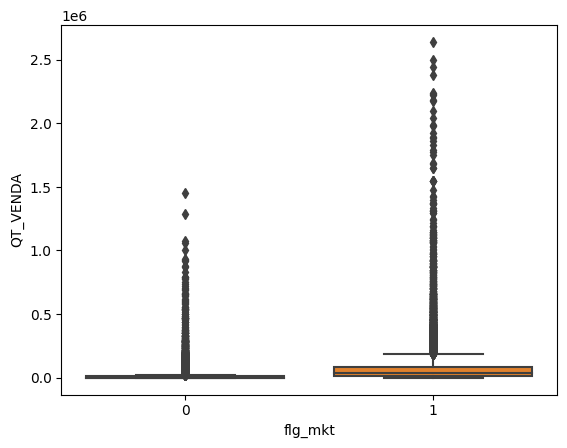

In [65]:
sns.boxplot(x=df_mkt_2['flg_mkt'],y=df_mkt_2['QT_VENDA']);

No novo boxplot temos uma visão mais claro do que acontece, e vemos algumas pistas de que as campanhas podem levar a maiores quanitidades de vendas.

## Indicador de existência ou não de datas comemorativas no ciclo

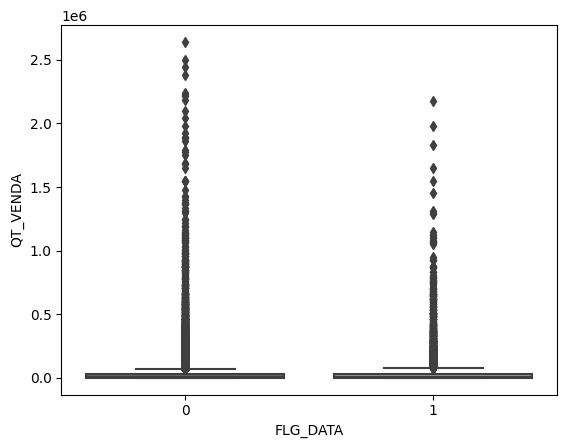

In [66]:
sns.boxplot(x=df_4['FLG_DATA'],y=df_4['QT_VENDA']);

Aqui temos valores balanceados para a existência ou não de datas comemorativas

## Analisando a relação entre as variáveis numéricas e o target

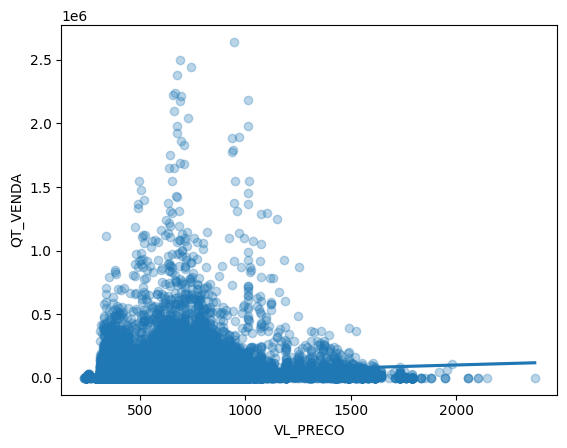

In [67]:
# variavel de preco
sns.regplot(x='VL_PRECO', y='QT_VENDA', data=df_4, scatter_kws={'alpha':0.3});

Aqui vemos que existe uma aglomeração maior dos pontos para valores mais baixos, ou seja para valores mais baixos e valores médios existe uma maior quantidade de venda, e para os valores maiores as quantidades são naturalmente mais baixas.

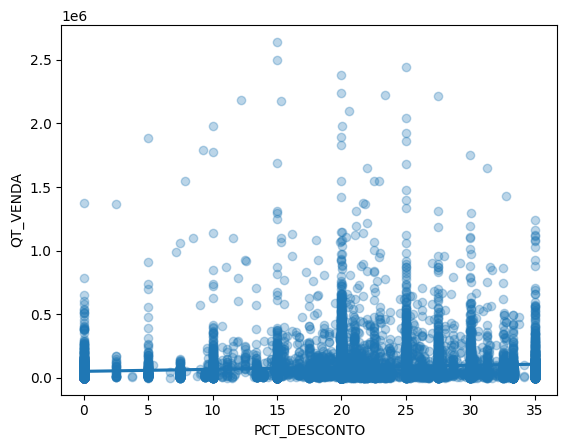

In [69]:
# variavel de desconto
sns.regplot(x='PCT_DESCONTO', y='QT_VENDA', data=df_4, scatter_kws={'alpha':0.3});

Para o percentual de desconto aplicado na venda vemos que os descontos a partir de 10% comecam a apresentar uma quantidade maior de vendas e isso vai se pronunciando conforme os desconros aumentam. Aqui tambem vale a hipotese que pode existir uma maior quantidade de produtos com descontos entre 20 e 30%.
  
**Nota**: o comportamento parece quase ordinal

## Considerações e conclusões da análise exploratória
Vamos agora apresentar algumas conclusões e considerações da análise, assim como as decisões que partiram da mesma:  
- Existem valores extremos nas nossas features, e pensando no fato de que estes podem ser importantes para o negócio os mesmos serão mantidos por hora
- Apesar dos valores extremos iniciaremos com um modelo de regressão linear, pois é um modelo simples que pode ser treinado rapidamente, além de ser o ponto de partida quando pensamos em problemas de regressão
- A variável `COD_MATERIAL` que se refere ao código do produto não será utilizada como feature, já que a mesma possui 2252 valores distintos podendo nos levar a overfitting e aumento na complexidade do modelo
- As flags de marketing serão unidas em uma só coluna indicando se existe campanha de marketing atuando ou não

# Feature Engineering
Sabe-se que algumas técnicas de Feature Engineering aprendem parâmetros dos dados, por isso é importante isolar o set de treino antes de iniciar a engenharia de features. Porem nesse problemas existem colunas como as de ciclo e marcas que podem estar presentes apenas no set de teste, logo para nao atrapalhar mapeamentos deste tipo irei comecar com a parte referente a feature engineering para depois realizar o split.
  
Nessa etapa iremos lidar com:
- Missing values
- Colunas de campanha de marketing
- Encoding da variavel temporal
- Encoding de variaveis categoricas
- Estandardização da variável de preço

## Missing values
Para os valores faltantes temos duas variáveis numéricas: VL_PRECO e PCT_DESCONTO. Além disso também precisamos lidar com as flags de marketing.

### Variáveis numéricas
Nossas variáveis numéricas serão tratadas de maneiras diferentes alinhadas às análises realizadas.  
**VL_PRECO**  
Para a variável de preço vamos imputar os nulos com valores iguais a  média:
- Adicionar uma variável binária como uma variável de indicação
- Em seguida substituir os valores faltantes da variável original com a média
  


In [71]:
# criando uma copia do df 4
df_to_split = df_4.copy()

# substituindo valores faltantes de VL_PRECO
# calcular a media 
val_medio = df_4['VL_PRECO'].mean()
print('VL_PRECO', val_medio)

#substituir valores pela media
df_to_split['VL_PRECO'].fillna(val_medio, inplace=True)

# checar se ainda existem valores faltantes
df_to_split['VL_PRECO'].isnull().sum()

VL_PRECO 542.4679818779306


0

**PCT_DESCONTO**  
Esta variável é  um pouco mais sensível, existe a possibilidade dos valores se apresentarem como nulos porque ele simplesmente não possuem desconto e pode ser um pouco incoerente adicionar um valor médio próximo a 20% de desconto para quase 70% dos nossos dados. Logo faremos o seguinte:
- Adicionar uma variável binária como uma variável de indicação
- Em seguida substituir os valores faltantes da variável original por zero

In [72]:
# substituir os valores por zero
df_to_split['PCT_DESCONTO'].fillna(0, inplace=True)

# verificando a presenca de nulor
df_to_split['PCT_DESCONTO'].isnull().sum()

0

## Variáveis indicadoras de campanha de marketing
Como visto anteriormente a decisão relacionada às variáveis de marketing foi criar um indicador de se existe ou não uma campanha em apenas uma coluna, desse modo podemos balancear um pouco mais o dataset, já que essas colunas tem sua importância mas tem em sua maioria valores iguais a zero.  
Para isso fazemos o seguinte:
- criamos uma coluna FLG_CAMPANHA_MKT indicando a existência ou não de uma campanha
- As colunas indicadoras de cada campanha são excluidas

In [73]:
# listando as campanhas de marketing
campanhas_mkt = ['FLG_CAMPANHA_MKT_A', 'FLG_CAMPANHA_MKT_B', 'FLG_CAMPANHA_MKT_C', 'FLG_CAMPANHA_MKT_D', 'FLG_CAMPANHA_MKT_E', 'FLG_CAMPANHA_MKT_F']

# Verificando dimensao do df
print(df_to_split.shape)

# criar uma nova coluna com valo 1 caso o item apresente alguma das 
# campanhas de marketing, caso contrario 0
df_to_split['flg_mkt'] = np.where((df_to_split[campanhas_mkt] != 0).any(axis=1), 1, 0)

# Verificando dimensao dos sets de treino e teste novamente
print(df_to_split.shape)

# eliminando as colunas de campanha
df_to_split.drop(columns=campanhas_mkt, inplace=True)

# Verificando dimensao dos sets de treino e teste uma ultima vez
print(df_to_split.shape)

(52042, 14)
(52042, 15)
(52042, 9)


## Encoding das variáveis categoricas

Pelo que pode ser visto no box plot de DES_CATEGORIA_MATERIAL e DES_MARCA_MATERIAL existem pesos diferentes na quantidade de vendas para estas variaveis, para tentar capturar isso vamos usar o encoder abaixo que leva em consideração a média das quantidades dos produtos vendidos.

In [74]:
# esta funcao tem o objetivo de realizar o encoding das variaveis categoricas
# o menor valor se refere a categoria com a menor media
# das quantidades vendidas

def encoding_categoria_produto(df, var, target):
    
    # ordenar as categorias da menor para a maior valor de 
    # quantidades de itens vendidos
    labels_ordenadas = df.groupby([var])[target].mean().sort_values().index

    # criar um dicionario mapeando as categorias ordenadas
    ordinal_label = {k: i for i, k in enumerate(labels_ordenadas, 0)}
    
    print(var, ordinal_label)

    # use the dictionary to replace the categorical strings by integers
    df[var] = df[var].map(ordinal_label)

In [75]:
cat_vars = ['DES_CATEGORIA_MATERIAL', 'DES_MARCA_MATERIAL']
for var in cat_vars: 
    encoding_categoria_produto(df_to_split, var, 'QT_VENDA')

DES_CATEGORIA_MATERIAL {'anon_S30': 0, 'anon_S18': 1, 'anon_S5': 2, 'anon_S11': 3, 'anon_S2': 4, 'anon_S12': 5}

DES_MARCA_MATERIAL {'anon_S94': 0, 'anon_S93': 1, 'anon_S55': 2, 'anon_S60': 3, 'anon_S65': 4, 'anon_S48': 5, 'anon_S74': 6, 'anon_S76': 7, 'anon_S77': 8, 'anon_S79': 9, 'anon_S72': 10, 'anon_S83': 11, 'anon_S90': 12, 'anon_S92': 13, 'anon_S82': 14, 'anon_S87': 15, 'anon_S91': 16, 'anon_S84': 17, 'anon_S86': 18, 'anon_S85': 19, 'anon_S71': 20, 'anon_S68': 21, 'anon_S63': 22, 'anon_S62': 23, 'anon_S61': 24, 'anon_S78': 25, 'anon_S66': 26, 'anon_S75': 27, 'anon_S70': 28, 'anon_S64': 29, 'anon_S58': 30, 'anon_S57': 31, 'anon_S73': 32, 'anon_S69': 33, 'anon_S67': 34, 'anon_S89': 35, 'anon_S49': 36, 'anon_S53': 37, 'anon_S56': 38, 'anon_S51': 39, 'anon_S59': 40, 'anon_S44': 41, 'anon_S43': 42, 'anon_S52': 43, 'anon_S45': 44, 'anon_S36': 45, 'anon_S38': 46, 'anon_S40': 47, 'anon_S37': 48, 'anon_S27': 49, 'anon_S41': 50, 'anon_S42': 51, 'anon_S16': 52, 'anon_S54': 53, 'anon_S29': 5

In [76]:
# verificando o df
print(df_to_split.shape)
df_to_split.head()

(52042, 9)


,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,PCT_DESCONTO,VL_PRECO,QT_VENDA,flg_mkt
0,6246,201908,5,37,1,0.0,461.4,240.0,0
1,6246,201915,5,37,0,0.0,461.4,240.0,0
2,6306,201916,5,37,1,0.0,521.4,240.0,0
3,6480,201801,5,65,0,0.0,833.4,528.0,0
4,6480,201802,5,65,0,0.0,833.4,564.0,0


## Encoding da variável temporal - ciclo
Para esta feature como mencionado nessa exploração, vamos seguir os seguintes passos:
- Dividir em duas colunas, ano e ciclo
- tanto ano quanto ciclo serão mapeados com números inteiros

[201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812, 201813, 201814, 201815, 201816, 201817, 201818, 201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912, 201913, 201914, 201915, 201916, 201917, 202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012, 202013, 202014, 202015, 202016, 202017, 202101]

In [77]:
def temporal_encoder(df, var_temporal):
    # criando colunas ANO e CICLO
    df['ANO'] = df[var_temporal].astype(str).str[:4]
    df['CICLO'] = df[var_temporal].astype(str).str[-2:]
    
    # mapeando a variavel ano
    year_map = {'2018': 1, '2019': 2, '2020':3, '2021':3}
    df['ANO'] = df['ANO'].map(year_map)
    

In [78]:
temporal_encoder(df_to_split, 'COD_CICLO')

In [79]:
print(df_to_split.shape)
df_to_split.head()

(52042, 11)


,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,PCT_DESCONTO,VL_PRECO,QT_VENDA,flg_mkt,ANO,CICLO
0,6246,201908,5,37,1,0.0,461.4,240.0,0,2,08
1,6246,201915,5,37,0,0.0,461.4,240.0,0,2,15
2,6306,201916,5,37,1,0.0,521.4,240.0,0,2,16
3,6480,201801,5,65,0,0.0,833.4,528.0,0,1,01
4,6480,201802,5,65,0,0.0,833.4,564.0,0,1,02


## Variável numérica 

A feature numérica VL_PRECO apresenta uma cauda longa para a direita, logo usaremos a transformação BOX-COX para obter uma distribuição mais próxima da normal.
  
Também usaremos uma transformação para o target, porém para facilitar a volta da transformação usaremos uma transformação logarítmica mais adiante (no split de treino e teste).

In [80]:
# Aplicando transformacao box-cox na variavel vl_preco
df_to_split['VL_PRECO_BOX_COX'], lam = boxcox(df_to_split['VL_PRECO'])

In [81]:
print(df_to_split.shape)
df_to_split.head()

(52042, 12)


,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,PCT_DESCONTO,VL_PRECO,QT_VENDA,flg_mkt,ANO,CICLO,VL_PRECO_BOX_COX
0,6246,201908,5,37,1,0.0,461.4,240.0,0,2,08,0.704384
1,6246,201915,5,37,0,0.0,461.4,240.0,0,2,15,0.704384
2,6306,201916,5,37,1,0.0,521.4,240.0,0,2,16,0.704403
3,6480,201801,5,65,0,0.0,833.4,528.0,0,1,01,0.704450
4,6480,201802,5,65,0,0.0,833.4,564.0,0,1,02,0.704450


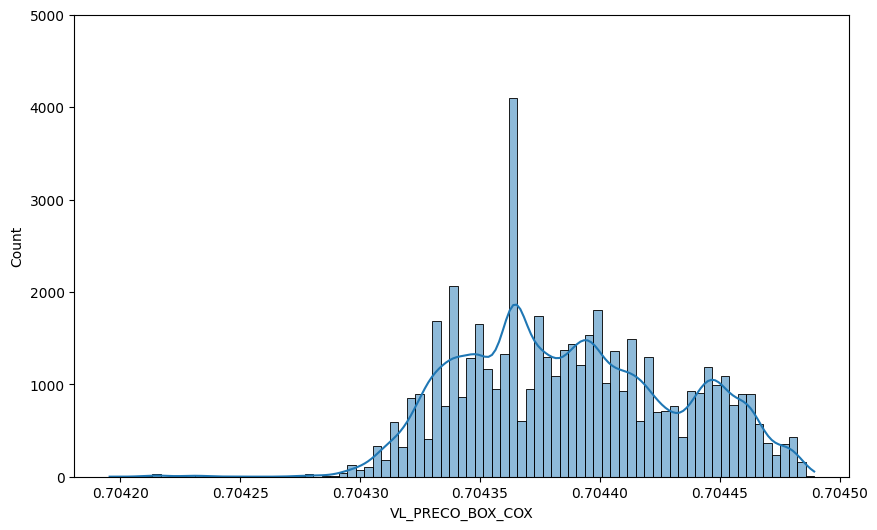

In [82]:
# Distribuicao da varial VL_PRECO
plt.figure(figsize=(10,6))
sns.histplot(data=df_to_split, x='VL_PRECO_BOX_COX', kde=True)
plt.ylim(0, 5000);

## Train-test split + split dos ciclos a serem previstos
  
Vamos iniciar separando os valores a serem previstos, ou seja, aqueles com COD_CICLO iguais a 202016, 202017, 202101.

In [120]:
# selecionando os dados do datarame inicial para serem feitas as previsoes ao final
df_previsao = df_to_split[df_to_split['COD_CICLO'].isin([202016, 202017, 202101])]

print(df_previsao.shape)

df_previsao.head()

(3148, 12)


,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,PCT_DESCONTO,VL_PRECO,QT_VENDA,flg_mkt,ANO,CICLO,VL_PRECO_BOX_COX
29,7098,202101,5,44,0,0.0,791.4,NaN,0,3,01,0.704447
47,7230,202016,5,51,1,0.0,863.4,NaN,0,3,16,0.704453
48,7230,202101,5,51,0,0.0,863.4,NaN,0,3,01,0.704453
113,10104,202016,5,80,1,0.0,809.4,NaN,0,3,16,0.704448
114,10104,202017,5,80,1,0.0,809.4,NaN,0,3,17,0.704448


In [121]:
# Selecionaodo os dados do dataframe sem outliers para treino e teste
df_train_test = df_to_split[~df_to_split['COD_CICLO'].isin([202016, 202017, 202101])]

print(df_train_test.shape)

df_train_test.head()

(48894, 12)


,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,PCT_DESCONTO,VL_PRECO,QT_VENDA,flg_mkt,ANO,CICLO,VL_PRECO_BOX_COX
0,6246,201908,5,37,1,0.0,461.4,240.0,0,2,08,0.704384
1,6246,201915,5,37,0,0.0,461.4,240.0,0,2,15,0.704384
2,6306,201916,5,37,1,0.0,521.4,240.0,0,2,16,0.704403
3,6480,201801,5,65,0,0.0,833.4,528.0,0,1,01,0.704450
4,6480,201802,5,65,0,0.0,833.4,564.0,0,1,02,0.704450


In [122]:
# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    df_train_test.drop(['COD_MATERIAL','COD_CICLO','VL_PRECO','QT_VENDA'], axis=1),
    df_train_test['QT_VENDA'], # target
    test_size=0.2, # proporcao do dataset a ser alocado para teste
    random_state=42, # seed
)

X_train.shape, X_test.shape

((39115, 8), (9779, 8))

## Modelo 1 - RL

In [123]:
# Transformando o target - log transform
y_train = np.log(y_train)
y_test = np.log(y_test)

# Instanciando o modelo
lm_1 = LinearRegression()

# Treinando o modelo
lm_1.fit(X_train, y_train)

LinearRegression()

In [124]:
# Treinando o modelo com o set de treino
y_pred_lm_1_train = lm_1.predict(X_train)

# Avaliando o set de treino com o MAE
mae_lm_1_train = MAE(np.exp(y_train),np.exp(y_pred_lm_1_train))
print('MAE LR 1 treino: {:.2f}'.format(mae_lm_1_train))

# Avaliando o set de treino com o R2
r2 = r2_score(np.exp(y_train),np.exp(y_pred_lm_1_train))
print('R-quadrado LR 1 treino:', r2)

# Avaliando o modelo com o MAPE
mape_lm_1_train = MAPE(np.exp(y_train),np.exp(y_pred_lm_1_train))
print('MAE LR 1 treino: {:.2f}'.format(mape_lm_1_train))

MAE LR 1 treino: 27157.53
R-quadrado LR 1 treino: 0.10792934857085024
MAE LR 1 treino: 2.73


In [125]:
# Treinando o modelo com o set de test
y_pred_lm_1 = lm_1.predict(X_test)

# Avaliando o set de treino com o MAE
rmse_lm_1 = MAE(np.exp(y_test),np.exp(y_pred_lm_1))
print('MAE LR 1 teste: {:.2f}'.format(rmse_lm_1))

# Avaliando o set de treino com o R2
r2 = r2_score(np.exp(y_test),np.exp(y_pred_lm_1))
print('R-quadrado LR 1 teste:', r2)

# Avaliando o modelo com o MAPE
rmse_lm_1 = MAPE(np.exp(y_test),np.exp(y_pred_lm_1))
print('MAPE LR 1 teste: {:.2f}'.format(rmse_lm_1))

MAE LR 1 teste: 27891.48
R-quadrado LR 1 teste: 0.0934846898559587
MAPE LR 1 teste: 2.65


O modelo nao da sinal de overfiting, vamos testar uma validacao cruzada pensando no split dos sets de treino e test

## Cross validation k-fold

In [126]:
X_cv = pd.concat([X_train, X_test], axis=0)

In [127]:
y_cv = pd.concat([y_train, y_test], axis=0)

In [130]:
# Instanciando a KFold
kf = KFold(n_splits=6, shuffle=True, random_state=5)

reg = LinearRegression()

# Compute 6-fold cross-validation scores
cv_scores = cross_val_score(reg, X_cv, y_cv, cv=kf)

# Aqui nao irei verificar os scores, ja que por conta da
# transformacao logaritimica serao inevitavelmente melhores que os anteriores
# print(cv_scores)

In [131]:
y_pred_cv = cross_val_predict(reg, X_cv, y_cv, cv=kf)

In [133]:
# MAE
mae_cv = MAE(np.exp(y_cv),np.exp(y_pred_cv))
print('MAE LR 1 CV: {:.2f}'.format(mae_cv))

# R2
r2 = r2_score(np.exp(y_cv),np.exp(y_pred_cv))
print('R-quadrado LR 1 CV:', r2)

# MAPE CV
mape_cv = MAPE(np.exp(y_cv),np.exp(y_pred_cv))
print('MAPE LR 1 teste: {:.2f}'.format(mape_cv))

MAE LR 1 CV: 27288.00
R-quadrado LR 1 CV: 0.10719712908258505
MAPE LR 1 teste: 2.72


Com esses resultados podemos ver que o modelo realmente está performando mal, o que era esperado devido a presença de outliers, principalmente se tratando de uma regressão linear. O MAPE possui um valor pequeno, mas este valor pode nos levar a enganos já que como existem valores altos, podemos ter valores bem elevados no denominador que podem resultar em valores pequenos.

Logo vamos tentar retirar os upper 1% de VL_PRECO e QT_VENDA para reavaliar os modelos.

## remover os uper 1% de VL_PRECO QT_VENDA

In [163]:
# Retirando upper 1%
df_out = df_to_split[(df_to_split['QT_VENDA'] < 418508.10) | (df_to_split['QT_VENDA'].isnull())].copy()

df_out.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,PCT_DESCONTO,VL_PRECO,QT_VENDA,flg_mkt,ANO,CICLO,VL_PRECO_BOX_COX
0,6246,201908,5,37,1,0.0,461.4,240.0,0,2,08,0.704384
1,6246,201915,5,37,0,0.0,461.4,240.0,0,2,15,0.704384
2,6306,201916,5,37,1,0.0,521.4,240.0,0,2,16,0.704403
3,6480,201801,5,65,0,0.0,833.4,528.0,0,1,01,0.704450
4,6480,201802,5,65,0,0.0,833.4,564.0,0,1,02,0.704450


In [164]:
# Retirando upper 1%
df_out = df_out[(df_out['VL_PRECO'] < 1534.66) | (df_out['VL_PRECO'].isnull())].copy()

df_out.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,PCT_DESCONTO,VL_PRECO,QT_VENDA,flg_mkt,ANO,CICLO,VL_PRECO_BOX_COX
0,6246,201908,5,37,1,0.0,461.4,240.0,0,2,08,0.704384
1,6246,201915,5,37,0,0.0,461.4,240.0,0,2,15,0.704384
2,6306,201916,5,37,1,0.0,521.4,240.0,0,2,16,0.704403
3,6480,201801,5,65,0,0.0,833.4,528.0,0,1,01,0.704450
4,6480,201802,5,65,0,0.0,833.4,564.0,0,1,02,0.704450


In [165]:
# Selecionaodo os dados do dataframe sem outliers para treino e teste
df_train_test_2 = df_out[~df_out['COD_CICLO'].isin([202016, 202017, 202101])]

print(df_train_test_2.shape)

df_train_test_2.head()



(47990, 12)


,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,PCT_DESCONTO,VL_PRECO,QT_VENDA,flg_mkt,ANO,CICLO,VL_PRECO_BOX_COX
0,6246,201908,5,37,1,0.0,461.4,240.0,0,2,08,0.704384
1,6246,201915,5,37,0,0.0,461.4,240.0,0,2,15,0.704384
2,6306,201916,5,37,1,0.0,521.4,240.0,0,2,16,0.704403
3,6480,201801,5,65,0,0.0,833.4,528.0,0,1,01,0.704450
4,6480,201802,5,65,0,0.0,833.4,564.0,0,1,02,0.704450


In [166]:
# Separando em treino e teste
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    df_train_test_2.drop(['COD_MATERIAL','COD_CICLO','VL_PRECO','QT_VENDA'], axis=1),
    df_train_test_2['QT_VENDA'], # target
    test_size=0.2, # proporcao do dataset a ser alocado para teste
    random_state=42, # seed
)

X_train_2.shape, X_test_2.shape

((38392, 8), (9598, 8))

In [167]:
# Transformando o target
y_train_2 = np.log(y_train_2)
y_test_2 = np.log(y_test_2)

In [168]:
# Instanciando o modelo
lm_2 = LinearRegression()

# treinando o modelo
lm_2.fit(X_train_2, y_train_2)

LinearRegression()

In [181]:
# Realizando a previsao com o set de treino
y_pred_lm_2_train = lm_2.predict(X_train_2)

# MAE
mae_lm_2 = MAE(np.exp(y_train_2),np.exp(y_pred_lm_2_train))
print('MAE LR 2 treino: {:.2f}'.format(mae_lm_2))

# R2
r2_lm_2 = r2_score(np.exp(y_train_2),np.exp(y_pred_lm_2_train))
print('R-quadrado LR 2 treino: {:.2f}'.format(r2_lm_2))

# MAPE
mape_lm_2 = MAPE(np.exp(y_train_2),np.exp(y_pred_lm_2_train))
print('MAPE LR 2 treino: {:.2f}'.format(rmse_lm_2))

MAE LR 2 treino: 20816.25
R-quadrado LR 2 treino: 0.18
MAPE LR 2 treino: 2.64


In [170]:
# Realizando a previsao com o set de teste
y_pred_lm_2_test = lm_2.predict(X_test_2)

# Evaluate the test set RMSE
rmse_lm_2 = MAE(np.exp(y_test_2),np.exp(y_pred_lm_2_test))
# Print rmse_test
print('MAE LR 1 teste: {:.2f}'.format(rmse_lm_2))
r2_2 = r2_score(np.exp(y_test_2),np.exp(y_pred_lm_2_test))
print('R-squared LR 1 teste:', r2_2)
rmse_lm_2 = MAPE(np.exp(y_test_2),np.exp(y_pred_lm_2_test))
# Print rmse_test
print('MAPE LR 1 teste: {:.2f}'.format(rmse_lm_2))

MAE LR 1 teste: 20520.34
R-squared LR 1 teste: 0.1854531776458439
MAPE LR 1 teste: 2.60


In [172]:
# Unindo sets de treino e teste
X_cv_2 = pd.concat([X_train_2, X_test_2], axis=0)
y_cv_2 = pd.concat([y_train_2, y_test_2], axis=0)

In [175]:
# Instanciando a KFold
kf_2 = KFold(n_splits=10, shuffle=True, random_state=42)

reg_2 = LinearRegression()

# Compute 6-fold cross-validation scores
cv_scores = cross_val_score(reg_2, X_cv_2, y_cv_2, cv=kf_2)

# Aqui nao irei verificar os scores, ja que por conta da
# transformacao logaritimica serao inevitavelmente melhores que os anteriores
# print(cv_scores)

In [176]:
y_pred_cv_2 = cross_val_predict(reg_2, X_cv_2, y_cv_2, cv=kf_2)

In [182]:
# MAE
mae_cv_2 = MAE(np.exp(y_cv_2),np.exp(y_pred_cv_2))
print('MAE CV 2: {:.2f}'.format(mae_cv_2))

# R2
r2_cv_2 = r2_score(np.exp(y_cv_2),np.exp(y_pred_cv_2))
print('R-quadrado CV 2:', r2_cv_2)

# MAPE CV
mape_cv_2 = MAPE(np.exp(y_cv_2),np.exp(y_pred_cv_2))
print('MAPE CV 2: {:.2f}'.format(mape_cv_2))

MAE CV 2: 20752.24
R-quadrado CV 2: 0.1794360718628184
MAPE CV 2: 2.64


Aqui vemos que realmente a retirada de Outliers melhora o resultado do modelo. Com isso vamos evoluir um pouco o modelo testando um Random Forest simples, apenas definindo o número de árvores de decisão para o mesmo.
 
Com a presença de outliers provavelmente esse modelo nos trará uma melhora de performance.

In [179]:
# Instanciando o Random Forest
rf = RandomForestRegressor(n_estimators=1000,
            random_state=42)

In [180]:
# treinando o modelo
rf.fit(X_train_2, y_train_2) 

RandomForestRegressor(n_estimators=1000, random_state=42)

In [183]:
# Realizando a previsao
y_pred_rf = rf.predict(X_test_2)

In [186]:
# MAE
mae_rf = MAE(np.exp(y_test_2), np.exp(y_pred_rf))
print('RF MAE: {:.2f}'.format(mae_rf))

# R2
r2_rf = r2_score(np.exp(y_test_2), np.exp(y_pred_rf))
print('R-quadrado RF: {:.2f}'.format(r2_rf))

# MAPE
mape_rf = MAPE(np.exp(y_test_2), np.exp(y_pred_rf))
print('RF MAPE: {:.2f}'.format(mape_rf))

RF MAE: 16349.44
R-quadrado RF: 0.45
RF MAPE: 2.37


Como esperado houve uma melhora na performance do modelo, nosso R2 consegue explicar melhor a variabilidade dos dados e o MAE apresenta uma melhora. Com relação ao MAPE este segue pequeno, mas devemos novamente nos atentar ao ponto que como existem valores altos, podemos ter denominadores de valores elevados.

In [ ]:
# # Instanciando o random forest
# rf_tune = RandomForestRegressor(random_state=2)

# # No de arvores
# n_estimators = [500, 1000, 1500, 2000]

# # maxima profundidade da arvore
# max_depth = [20, 40, 80, 100]

# # numero minimo de amostras necessarios para o split
# min_samples_split = [2, 5, 10]

# # numero minimo de amostras necessarios em cada folha
# min_samples_leaf = [1, 2, 4]

# # criar o grid
# param_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}


# # Instantiate grid_rf
# grid_rf = GridSearchCV(estimator=rf,
#                        param_grid=param_grid,
#                        cv=3,
#                        verbose=1,
#                        n_jobs=-1)

In [ ]:
# grid_rf.fit(X_train_2, y_train_2)

**NOTA:** Infelizmente não foi possível rodar o grid search para otimização, pois rodar neste computador levaria muito tempo.

# Inserindo conceitos simples de Time Series

Como mencionado anteriormente, temos em mãos um problema de previsão de quantidades de vendas em meses subsequentes. Este fato pode nos levar a uma pergunta interessante por que não tratar este problema como uma série temporal, ou ao menos inserir conceitos da mesma em nossa solução.

Para isso vamos fazer um teste, inserir uma coluna com a média móvel de 3 períodos (ciclos) da variável QT VENDA. A partir disso tentaremos uma regressão utilizando apenas esta feature e em seguida usaremos as features já usadas anteriormente adicionando também a média móvel nas previsões.

## Criando a nova coluna `QT_VENDA_lagged_3`

In [197]:
# criando uma copia do dataframe tratado e pronto para realizar os splits
df_media_movel_3 = df_to_split.copy()

# ordenando o dataframe port COD_MATERIAL e COD_CICLO em ordem crescente
df_media_movel_3.sort_values(by=['COD_MATERIAL', 'COD_CICLO'], ascending=True, inplace=True)


# Adicionar uma nova coluna QT_VENDA_lagged_3 que apresenta a media movel dos ultimos 3 periodos
df_media_movel_3['QT_VENDA_lagged_3'] = df_media_movel_3.groupby('COD_MATERIAL')['QT_VENDA'].rolling(window=3).mean().reset_index(0, drop=True)

# Substituindo os valores faltantes de 'QT_VENDA_lagged_3' com valores de 'QT_VENDA'
na_values = df_media_movel_3['QT_VENDA_lagged_3'].isna()
df_media_movel_3.loc[na_values, 'QT_VENDA_lagged_3'] = df_media_movel_3.loc[na_values, 'QT_VENDA']

# Para o step anterior como existem valores nulos para `QT_VENDA` para garantir que todos 
# terao um valor iremos substutir pela media
median_QT_VENDA = df['QT_VENDA'].median()
df_media_movel_3['QT_VENDA_lagged_3'].fillna(median_QT_VENDA, inplace=True)


In [198]:
df_media_movel_3.head(50)

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,PCT_DESCONTO,VL_PRECO,QT_VENDA,flg_mkt,ANO,CICLO,VL_PRECO_BOX_COX,QT_VENDA_lagged_3
0,6246,201908,5,37,1,0.0,461.40,240.0,0,2,08,0.704384,240.0
1,6246,201915,5,37,0,0.0,461.40,240.0,0,2,15,0.704384,240.0
2,6306,201916,5,37,1,0.0,521.40,240.0,0,2,16,0.704403,240.0
3,6480,201801,5,65,0,0.0,833.40,528.0,0,1,01,0.704450,528.0
4,6480,201802,5,65,0,0.0,833.40,564.0,0,1,02,0.704450,564.0
5,6480,201803,5,65,0,0.0,833.40,528.0,0,1,03,0.704450,540.0
6,6480,201804,5,65,0,0.0,833.40,540.0,0,1,04,0.704450,544.0
7,6480,201805,5,65,0,0.0,833.40,522.0,0,1,05,0.704450,530.0
8,6480,201806,5,65,0,0.0,833.40,540.0,0,1,06,0.704450,534.0
9,6480,201807,5,65,1,0.0,798.18,678.0,0,1,07,0.704447,580.0


## Regressão linear utilizando apenas a feature de médias móveis sem retirada dos upper 1% de VL_PRECO QT_VENDA

In [199]:
# log transform de QT_VENDA_lagged_3 column
df_media_movel_3['QT_VENDA_lagged_3_log'] = np.log(df_media_movel_3['QT_VENDA_lagged_3'])

# Selecionaodo os dados do dataframe sem outliers para treino e teste
df_train_test_ts_1 = df_media_movel_3[~df_media_movel_3['COD_CICLO'].isin([202016, 202017, 202101])]

# Separando em treino e teste
X_train_ts_1, X_test_ts_1, y_train_ts_1, y_test_ts_1 = train_test_split(
    df_train_test_ts_1.drop(['COD_MATERIAL','COD_CICLO','DES_CATEGORIA_MATERIAL', 'DES_MARCA_MATERIAL', 'PCT_DESCONTO','VL_PRECO','QT_VENDA', 'flg_mkt', 'ANO', 'CICLO', 'VL_PRECO_BOX_COX', 'FLG_DATA'], axis=1),
    df_train_test_ts_1['QT_VENDA'], # target
    test_size=0.2, # proporcao do dataset a ser alocado para teste
    random_state=42, # seed
)

X_train_ts_1.shape, X_test_ts_1.shape

y_train_ts_1 = np.log(y_train_ts_1)
y_test_ts_1 = np.log(y_test_ts_1)

lm_ts_1 = LinearRegression()
lm_ts_1.fit(X_train_ts_1, y_train_ts_1)

LinearRegression()

In [201]:
# previsao do set de teste
y_pred_ts_1 = lm_ts_1.predict(X_test_ts_1)

# MAE
mae_lm_ts_1 = MAE(np.exp(y_test_ts_1),np.exp(y_pred_ts_1))
print('MAE LR serie temporeal com valores extremos: {:.2f}'.format(mae_lm_ts_1))

# R2
r2_lm_ts_1= r2_score(np.exp(y_test_ts_1),np.exp(y_pred_ts_1))
print('R-quadrado LR serie temporeal com valores extremos:{:.2f}'.format(r2_lm_ts_1))

# MAPE
mape_lm_ts_1 = MAPE(np.exp(y_test_ts_1),np.exp(y_pred_ts_1))
print('MAPE  LR serie temporeal com valores extremos: {:.2f}'.format(mape_lm_ts_1))

MAE LR serie temporeal com valores extremos: 15308.83
R-quadrado LR serie temporeal com valores extremos:0.70
MAPE  LR serie temporeal com valores extremos: 0.38


Vemos que quando comparado aos valores do modelo análogo considerando os outliers tivemos uma grande melhoria para todas as métricas.

## Regressão linear utilizando apenas a feature de médias móveis com retirada dos upper 1% de VL_PRECO QT_VENDA

In [202]:
# Retirando upper 1%
df_media_movel_3_out = df_media_movel_3[(df_media_movel_3['QT_VENDA'] < 418508.10) | (df_media_movel_3['QT_VENDA'].isnull())].copy()
df_media_movel_3_out = df_media_movel_3_out[(df_media_movel_3_out['VL_PRECO'] < 1534.66) | (df_media_movel_3_out['VL_PRECO'].isnull())].copy()

In [223]:
# Selecionaodo os dados do dataframe sem outliers para treino e teste
df_train_test_ts_2 = df_media_movel_3_out[~df_media_movel_3_out['COD_CICLO'].isin([202016, 202017, 202101])]

# Separando em treino e teste
X_train_ts_2, X_test_ts_2, y_train_ts_2, y_test_ts_2 = train_test_split(
    df_train_test_ts_2.drop(['COD_MATERIAL','COD_CICLO','DES_CATEGORIA_MATERIAL', 'DES_MARCA_MATERIAL', 'PCT_DESCONTO','VL_PRECO','QT_VENDA', 'flg_mkt', 'ANO', 'CICLO', 'VL_PRECO_BOX_COX', 'FLG_DATA'], axis=1),
    df_train_test_ts_2['QT_VENDA'], # target
    test_size=0.2, # proporcao do dataset a ser alocado para teste
    random_state=42, # seed
)

X_train_ts_2.shape, X_test_ts_2.shape

y_train_ts_2 = np.log(y_train_ts_2)
y_test_ts_2 = np.log(y_test_ts_2)

lm_ts_2 = LinearRegression()
lm_ts_2.fit(X_train_ts_2, y_train_ts_2)

LinearRegression()

In [209]:
# previsao do set de teste
y_pred_ts_2 = lm_ts_2.predict(X_test_ts_2)

# MAE
mae_lm_ts_2 = MAE(np.exp(y_test_ts_2),np.exp(y_pred_ts_2))
print('MAE LR serie temporeal sem valores extremos: {:.2f}'.format(mae_lm_ts_2))

# R2
r2_lm_ts_2= r2_score(np.exp(y_test_ts_2),np.exp(y_pred_ts_2))
print('R-quadrado LR serie temporeal sem valores extremos:{:.2f}'.format(r2_lm_ts_2))

# MAPE
mape_lm_ts_2 = MAPE(np.exp(y_test_ts_2),np.exp(y_pred_ts_2))
print('MAPE  LR serie temporeal sem valores extremos: {:.2f}'.format(mape_lm_ts_2))

MAE LR serie temporeal sem valores extremos: 11453.85
R-quadrado LR serie temporeal sem valores extremos:0.68
MAPE  LR serie temporeal sem valores extremos: 0.38


Como já era esperado devido aos testes anteriores a retirada dos upper 1% melhora a performance do modelo. Vejamos agora o que acontece quando utilizamos as outras features.

## Regressão linear utilizando todas as features com retirada dos upper 1% de VL_PRECO QT_VENDA

In [208]:
# Separando em treino e teste
X_train_ts_3, X_test_ts_3, y_train_ts_3, y_test_ts_3 = train_test_split(
    df_train_test_ts_2.drop(['COD_MATERIAL','COD_CICLO','VL_PRECO','QT_VENDA'], axis=1),
    df_train_test_ts_2['QT_VENDA'], # target
    test_size=0.2, # proporcao do dataset a ser alocado para teste
    random_state=42, # seed
)

X_train_ts_3.shape, X_test_ts_3.shape

y_train_ts_3 = np.log(y_train_ts_3)
y_test_ts_3 = np.log(y_test_ts_3)

lm_ts_3 = LinearRegression()
lm_ts_3.fit(X_train_ts_3, y_train_ts_3)

LinearRegression()

In [210]:
# previsao do set de teste
y_pred_ts_3 = lm_ts_3.predict(X_test_ts_3)

# MAE
mae_lm_ts_3 = MAE(np.exp(y_test_ts_3),np.exp(y_pred_ts_3))
print('MAE LR serie temporeal sem valores extremos adicionando features: {:.2f}'.format(mae_lm_ts_3))

# R2
r2_lm_ts_3= r2_score(np.exp(y_test_ts_3),np.exp(y_pred_ts_3))
print('R-quadrado LR serie temporeal sem valores extremos adicionando features:{:.2f}'.format(r2_lm_ts_3))

# MAPE
mape_lm_ts_3 = MAPE(np.exp(y_test_ts_3),np.exp(y_pred_ts_3))
print('MAPE  LR serie temporeal sem valores extremos adicionando features: {:.2f}'.format(mape_lm_ts_3))

MAE LR serie temporeal sem valores extremos adicionando features: 9072.87
R-quadrado LR serie temporeal sem valores extremos adicionando features:0.78
MAPE  LR serie temporeal sem valores extremos adicionando features: 0.32


Usando todas as features usadas anteriormente conseguimos um resultado melhor ainda, vejamos como será a performance de previsão do set de treino para averiguar se há overfitting.

In [212]:
# previsao do set de teste
y_pred_ts_3_train = lm_ts_3.predict(X_train_ts_3)

# MAE
mae_lm_ts_3_train = MAE(np.exp(y_train_ts_3),np.exp(y_pred_ts_3_train))
print('MAE LR serie temporeal sem valores extremos adicionando features-treino: {:.2f}'.format(mae_lm_ts_3_train))

# R2
r2_lm_ts_3_train= r2_score(np.exp(y_train_ts_3),np.exp(y_pred_ts_3_train))
print('R-quadrado LR serie temporeal sem valores extremos adicionando features-treino:{:.2f}'.format(r2_lm_ts_3_train))

# MAPE
mape_lm_ts_3_train = MAPE(np.exp(y_train_ts_3),np.exp(y_pred_ts_3_train))
print('MAPE  LR serie temporeal sem valores extremos adicionando features-treino: {:.2f}'.format(mape_lm_ts_3_train))

MAE LR serie temporeal sem valores extremos adicionando features-treino: 9145.57
R-quadrado LR serie temporeal sem valores extremos adicionando features-treino:0.78
MAPE  LR serie temporeal sem valores extremos adicionando features-treino: 0.33


O resultado parece coerente, vamos ao modelo de random forests agora

In [214]:
# Instanciando o Random Forest
rf_ts = RandomForestRegressor(n_estimators=1000,
            random_state=42)

In [215]:
# treinando o modelo
rf_ts.fit(X_train_ts_3, y_train_ts_3)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [218]:
# Realizando a previsao
y_pred_rf_ts = rf_ts.predict(X_test_ts_3)

# MAE
mae_rf_ts = MAE(np.exp(y_test_ts_3),np.exp(y_pred_rf_ts))
print('MAE RF serie temporal: {:.2f}'.format(mae_rf_ts))

# R2
r2_rf_ts= r2_score(np.exp(y_test_ts_3),np.exp(y_pred_rf_ts))
print('R-quadrado RF serie temporal:{:.2f}'.format(r2_rf_ts))

# MAPE
mape_rs_ts = MAPE(np.exp(y_test_ts_3),np.exp(y_pred_rf_ts))
print('MAPE  RF serie temporal: {:.2f}'.format(mape_rs_ts))

MAE RF serie temporal: 7137.66
R-quadrado RF serie temporal:0.85
MAPE  RF serie temporal: 0.25


O modelo de Random forest melhorou ainda maia as nossas previsões, todas as métricas melhoraram com adição da coluna de média móvel de 3 períodos.

# Combinação de clusterização e regressão

Uma possível evolução e melhoria para este modelo poderia ser fazer uma clusterização e para cada um dos clusters definidos realizar uma regressão.
 
Inicialmente poderíamos pensar em construir clusters a partir da marca, categoria e valor do produto, e a partir desses realizar uma regressão.
 
Como essa análise seria mais profunda, tendo a necessidade de analisar esses clusters e entendê-los para então avaliar se vale a pena utilizá-los, essa abordagem não será utilizada no caso. Mesmo assim, vejamos de forma superficial o que estes clusters nos entregaram.

In [219]:
# selecionando as colunas para clusterizacao
cluster_cols = ['DES_CATEGORIA_MATERIAL', 'DES_MARCA_MATERIAL', 'VL_PRECO']

# Criar um dataframe com as colunas selecionadas
df_cluster = df_train_test_ts_2[cluster_cols].copy()

# Realizar um scale na coluna de preco
scaler = StandardScaler()
df_cluster[['VL_PRECO']] = scaler.fit_transform(df_cluster[['VL_PRECO']])

# Encontrar o numero otimo de clusters utilizando o silhouette score
scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    preds = kmeans.fit_predict(df_cluster)
    score = silhouette_score(df_cluster, preds)
    scores.append(score)
    print(f"Silhouette score for {i} clusters: {score:.2f}")


C:\Users\na_ca\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 2 clusters: 0.54


C:\Users\na_ca\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 3 clusters: 0.54


C:\Users\na_ca\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 4 clusters: 0.56


C:\Users\na_ca\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 5 clusters: 0.55


C:\Users\na_ca\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 6 clusters: 0.56


C:\Users\na_ca\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 7 clusters: 0.49


C:\Users\na_ca\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 8 clusters: 0.49


C:\Users\na_ca\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 9 clusters: 0.48


C:\Users\na_ca\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 10 clusters: 0.47


Avaliando o silhouette score temos nosso cluster ótimo com k =6. Vamos adicioná-lo ao nosso dataframe e verificar o número de observações para cada cluster.

In [220]:
# KMeans fit
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(df_cluster)

C:\Users\na_ca\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [224]:
# Adicionar a label de cluster no dataframe
df_clusters = df_train_test_ts_2.copy()
df_clusters['cluster'] = clusters


In [225]:
df_clusters.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,PCT_DESCONTO,VL_PRECO,QT_VENDA,flg_mkt,ANO,CICLO,VL_PRECO_BOX_COX,QT_VENDA_lagged_3,QT_VENDA_lagged_3_log,cluster
0,6246,201908,5,37,1,0.0,461.4,240.0,0,2,08,0.704384,240.0,5.480639,5
1,6246,201915,5,37,0,0.0,461.4,240.0,0,2,15,0.704384,240.0,5.480639,5
2,6306,201916,5,37,1,0.0,521.4,240.0,0,2,16,0.704403,240.0,5.480639,5
3,6480,201801,5,65,0,0.0,833.4,528.0,0,1,01,0.704450,528.0,6.269096,2
4,6480,201802,5,65,0,0.0,833.4,564.0,0,1,02,0.704450,564.0,6.335054,2


In [227]:
# Contando os diferentes numeros de observacao para cada cluster
cluster_counts = df_clusters.groupby('cluster').size()
print(cluster_counts)

cluster
0    14062
1     7002
2    18589
3      299
4     6687
5     1351
dtype: int64


O que podemos ver aqui é que temos 2 clusters maiores, 2 intermediários e um específico tem bem poucos valores, porém simplesmente observar o número de clusters não nos diz muitas coisas. 
  
Para saber se eles fazem sentido teríamos que entrar em análises bem mais profundas antes de testar uma regressão para cada cluster, especialmente levando em conta o número de amostras de cada cluster que para alguns é bem pouco. Como o tempo é limitado, os próximos passos ficam como recomendação.

## Conclusões e next steps
Este é um problema que possui diversas nuances muito interessantes e que poderia nos levar a diversas análises mais intensas, o que de fato nos tomaria muito tempo. Logo como o tempo que temos é limitado aqui ficam alguns possíveis next steps para o problema.
- Talvez tratar esse problema como uma série temporal usando por exemplo um ARIMA nos entregue bons resultados. Porém como visto nos resultados as demais features podem ajudar muito na previsão. Com isso, seria interessante continuar com as features dadas e adicionar algumas nuances de uma série temporal como feito com a coluna da média móvel de 3 períodos.
- Levando em conta a média móvel conseguimos obter um resultado bem melhor até mesmo sem retirar os valores mais extremos do dataset, chegando a um random forest que nos entrega bons resultados quando observamos o valor médio das quantidades de produtos vendidos e seu desvio.
- Uma possível evolução do problema como mencionado seria explorar clusterizados que levassem a diferentes modelos de regressão.
- Uma feature muito interessante de ser analisada com mais atenção e a das flags de marketing, poderia ser criada uma regra que traduzisse melhor as nuances da mesma ou poderia ser feita alguma clusterização para auxiliar neste ponto.
- Por fim algo simples que exige poder computacional, o tuning dos hiperparâmetros do random forest, que pode melhorar a performance do mesmo